# Use spectra of CTIO Data in January 2017 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 16th 2017
- update : February 15th 2017


This notebook is supposed to perform an atmospheric properties measurement on spectra




In [5]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print theNotebook

AnaAerCalibDataSim_Spectrum_HD60753


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [8]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [9]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [10]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [11]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
from scipy.interpolate import interp1d

In [16]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [17]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [18]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [19]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [20]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [21]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [22]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### Output directory for images generated in the notebook view (not true fits images)¶¶

In [23]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [24]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [25]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD60753'

### Output Fits file

In [26]:
outputdir="./spectrum_anaaer"

In [27]:
ensure_dir(outputdir)

In [28]:
output_file='AnaAtmAerFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [29]:
input_filelist=os.listdir(inputdir) 

In [30]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [31]:
print input_filelist[0:5]

['compSimRealSpectra_HD60753_20170118_289.fits'
 'compSimRealSpectra_HD60753_20170118_290.fits'
 'compSimRealSpectra_HD60753_20170118_291.fits'
 'compSimRealSpectra_HD60753_20170118_292.fits'
 'compSimRealSpectra_HD60753_20170118_293.fits']


In [32]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [33]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file     
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^compSimRealSpectra_HD60753_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [34]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [35]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [36]:
print indexes_files

[289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427]


In [37]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [38]:
sorted_numbers=indexes_files[sorted_indexes]

In [39]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138]


In [40]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [41]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_289.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_290.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_291.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_292.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD60753_20170118_293.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [42]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [43]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [44]:
print sorted_filenames.shape

(139,)


## Acces to spectrum data
----------------------------------

In [45]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [46]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [47]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [48]:
print len(all_dates)

139


## 1.) Show Spectra
==========================

In [49]:
NDATA=len(all_rightspectra_data)

In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        axarr[iy,ix].set_xlim(100.,1100.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

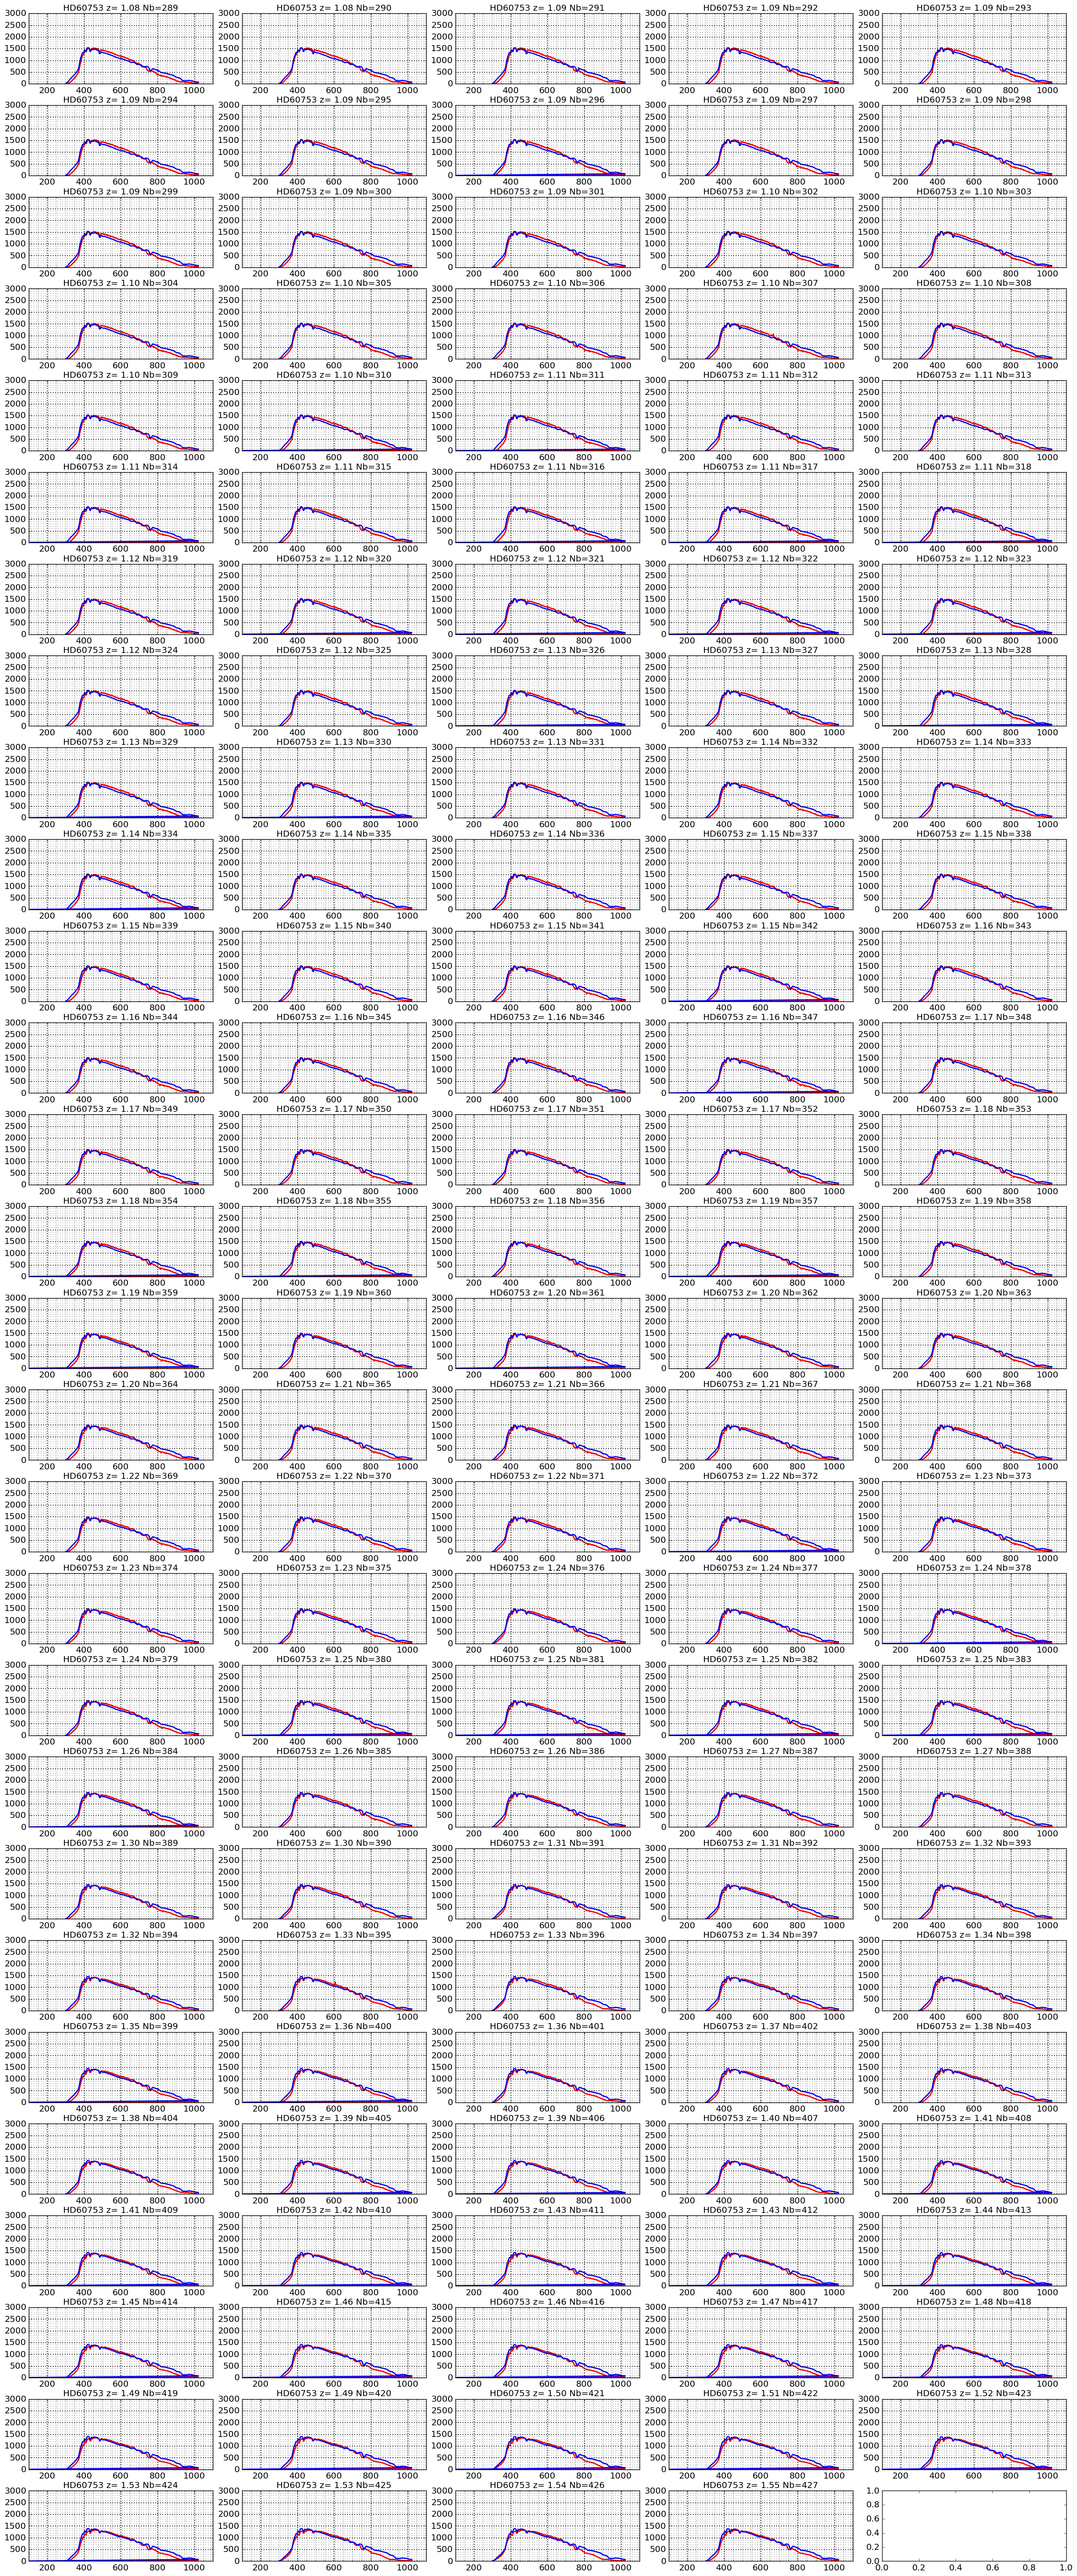

In [51]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [52]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [53]:
sel=1
thespectrum=all_rightspectra_data[sel]

In [54]:
#thespectrum

In [55]:
#print all_rightspectra_data[sel]

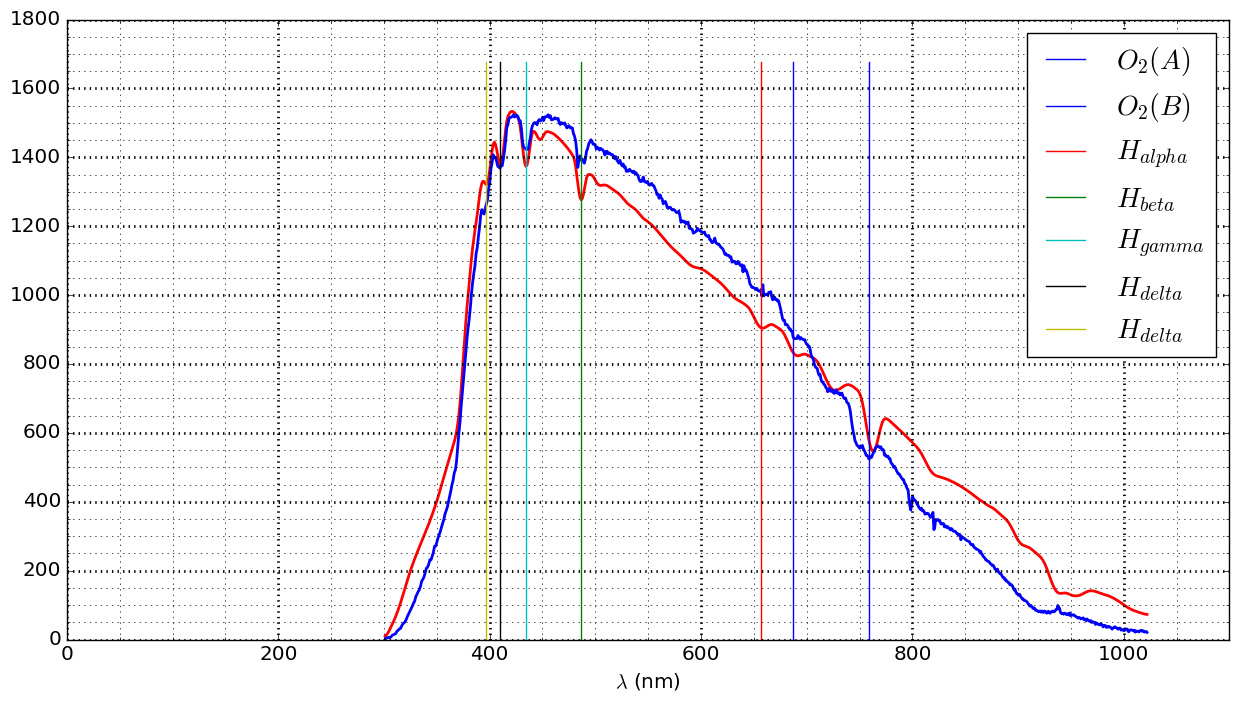

In [56]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## 2.) Study ratio Data/Sim spectra
============================================

In [57]:
def ShowRatioSpectra(thewl,thespectrum,thesimspec,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
                  
        ratio=thespectrum[index]/thesimspec[index]
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        
        if(all_expo[index] >0 ):
            ax.plot(thewl[index],ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")

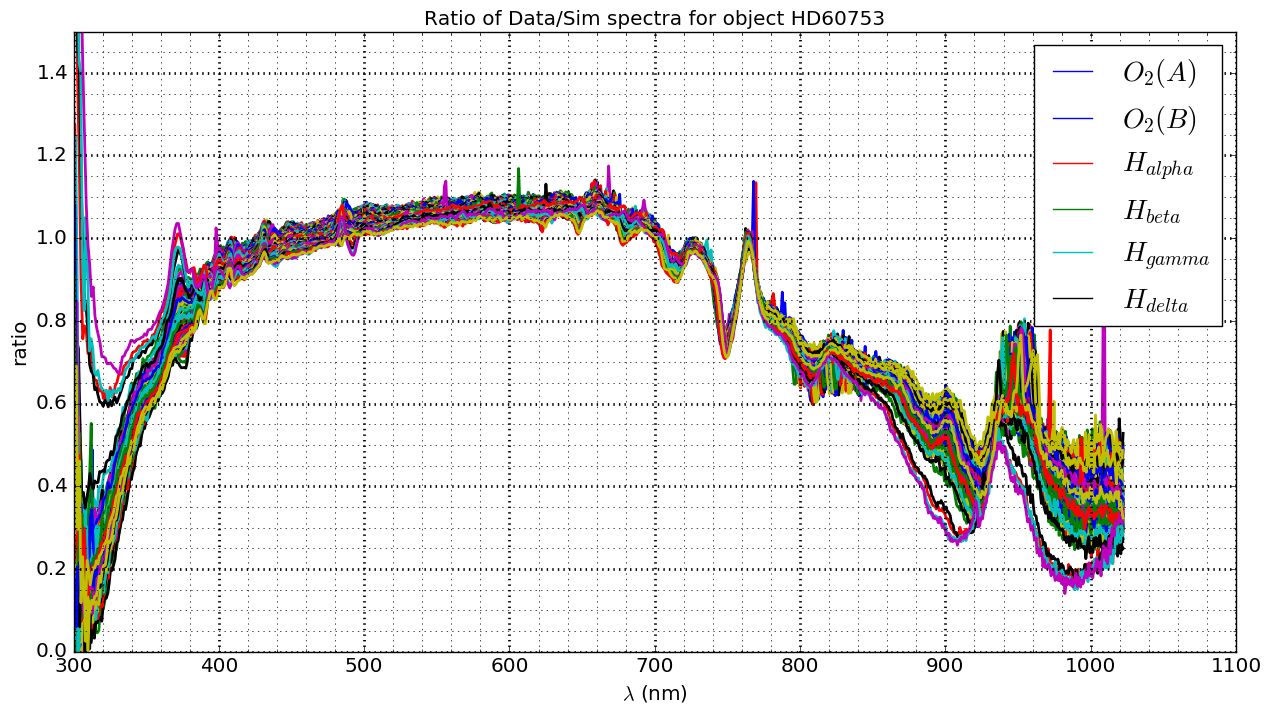

In [58]:
#all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name
ShowRatioSpectra(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,all_titles,object_name)




## Average of Ratio Data/Sim

In [59]:
#np.where(all_rightspectra_wl[1]>wlcut)

In [60]:
wlcut=400

In [61]:
def ShowRatioSpectraSum(thewl,thespectrum,thesimspec,wlcut,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)

    # Plot 1) show the ratio data/Sim
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_sum=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
         
        selectedindexes=np.where(all_rightspectra_wl[index]>wlcut)    
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
        
        ratio=sel_data/sel_sim ## Compute here the ratio data/sim
        
        if(all_expo[index]>0):
            all_ymin.append(ratio.min())
            all_ymax.append(ratio.max())
            all_sum.append(ratio.mean())
                       
            ax.plot(sel_wl,ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_xlim(300.,1000.)
    
    ## plot 2 
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(all_sum,'ro')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    title='Average of Ratio of Data/Sim spectra over wavelegth for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio average ")
    ax.set_xlabel(" image number")
    return np.array(all_sum)

### Ratio versus image number

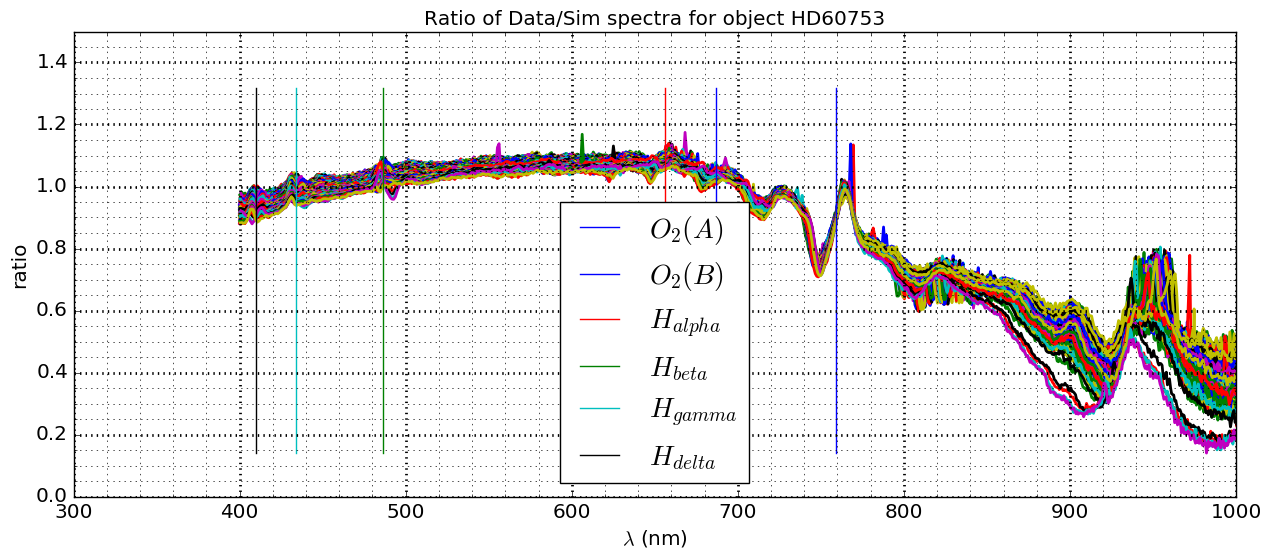

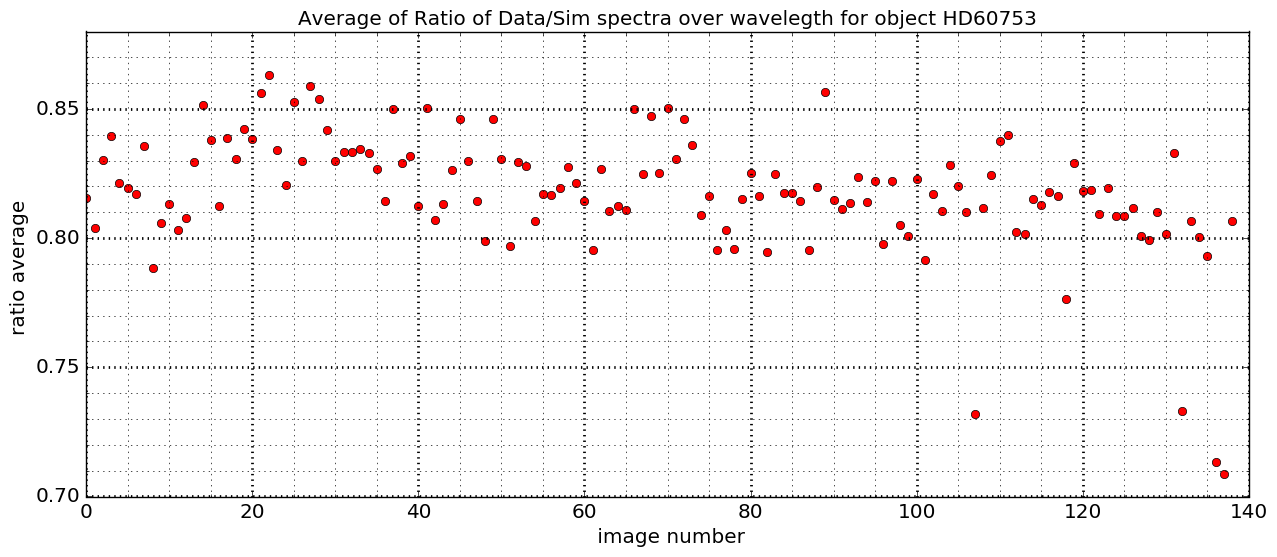

In [62]:
all_ratioaver=ShowRatioSpectraSum(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [63]:
np.where(all_expo==0.)

(array([], dtype=int64),)

In [64]:
print all_expo

[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0]


In [65]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

In [66]:
all_airmass

[1.084,
 1.085,
 1.086,
 1.086,
 1.087,
 1.088,
 1.089,
 1.09,
 1.091,
 1.092,
 1.093,
 1.094,
 1.095,
 1.096,
 1.097,
 1.098,
 1.099,
 1.1,
 1.101,
 1.102,
 1.103,
 1.105,
 1.106,
 1.107,
 1.108,
 1.11,
 1.111,
 1.112,
 1.114,
 1.115,
 1.116,
 1.118,
 1.119,
 1.121,
 1.122,
 1.123,
 1.125,
 1.126,
 1.128,
 1.13,
 1.131,
 1.133,
 1.134,
 1.136,
 1.138,
 1.14,
 1.141,
 1.143,
 1.145,
 1.147,
 1.148,
 1.15,
 1.152,
 1.154,
 1.156,
 1.158,
 1.16,
 1.162,
 1.164,
 1.166,
 1.168,
 1.17,
 1.172,
 1.174,
 1.177,
 1.179,
 1.181,
 1.183,
 1.186,
 1.188,
 1.19,
 1.193,
 1.195,
 1.198,
 1.2,
 1.202,
 1.205,
 1.208,
 1.21,
 1.213,
 1.215,
 1.218,
 1.221,
 1.223,
 1.226,
 1.229,
 1.232,
 1.235,
 1.237,
 1.24,
 1.243,
 1.246,
 1.249,
 1.252,
 1.255,
 1.259,
 1.262,
 1.265,
 1.268,
 1.271,
 1.297,
 1.302,
 1.307,
 1.313,
 1.318,
 1.323,
 1.329,
 1.334,
 1.34,
 1.345,
 1.351,
 1.357,
 1.363,
 1.369,
 1.375,
 1.381,
 1.387,
 1.394,
 1.4,
 1.407,
 1.413,
 1.42,
 1.427,
 1.434,
 1.441,
 1.448,
 1.455,
 1

In [67]:
#all_dt

In [68]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [69]:
#am=np.array(all_airmass)*.25

### Ratio versus image date

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


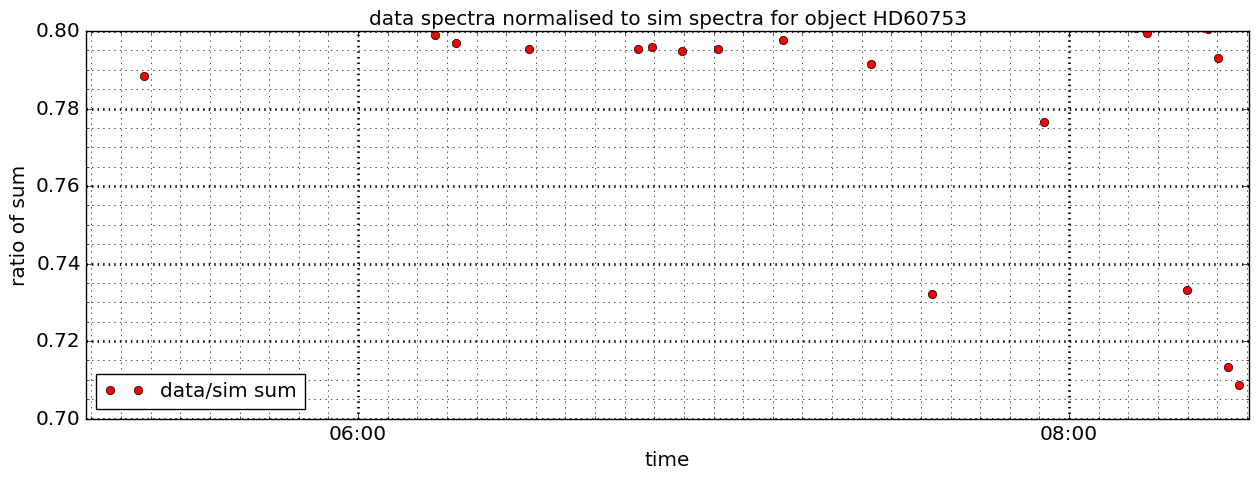

In [70]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_ratioaver,marker='o',color='red',lw=0,label='data/sim sum',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0.7,0.8)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='data spectra normalised to sim spectra for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

## 3.) Aerosols : phase 1 : (Data/Sim)(at z) / (Data/Sim)(at zmin)

In [71]:
def RemoveAbsorptionLines(thewl,thespectrum,thesimspec):
   
    
    WLMINAbs=np.array([405.,430.,480.,700,740])
    WLMAXAbs=np.array([415.,440.,500.,730,780])
    NAbsLines=WLMINAbs.shape[0]
    
    NBSPECTRA=len(thespectrum)
    
    all_selected_wl= []
    all_selected_dataspectrum= []
    all_selected_simspectrum= []
    
    for index in np.arange(0,NBSPECTRA):
        wl=np.copy(thewl[index])
        data=np.copy(thespectrum[index])
        sim=np.copy(thesimspec[index])
        
        not_selected_indexes=np.empty((0))  ### Create an empty array
               
        for iline in range(NAbsLines):     
        
            selected_to_add=np.where(np.logical_and(wl>WLMINAbs[iline],wl<WLMAXAbs[iline]))
            not_selected_indexes=np.append(not_selected_indexes,selected_to_add)

        
        all_selected_wl.append(np.delete(wl,not_selected_indexes))
        all_selected_dataspectrum.append(np.delete(data,not_selected_indexes))
        all_selected_simspectrum.append(np.delete(sim,not_selected_indexes))
        
        
    return np.array(all_selected_wl),np.array(all_selected_dataspectrum),np.array(all_selected_simspectrum) 

In [72]:
all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum=RemoveAbsorptionLines(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim)

In [73]:
print all_selected_wl[1].shape[0]
print all_selected_dataspectrum[1].shape[0]
print all_selected_simspectrum[1].shape[0]

677
677
677


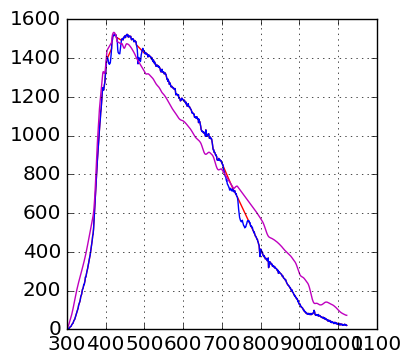

In [74]:
plt.plot(all_selected_wl[1],all_selected_dataspectrum[1],'r-')
plt.plot(all_rightspectra_wl[1],all_rightspectra_data[1],'b-')
plt.plot(all_selected_wl[1],all_selected_simspectrum[1],'m-')
plt.grid()

In [75]:
#all_airmass

## True Bouguer line on data spectrum

In [76]:
def bougline(x, a, b):
    return a*x + b

In [77]:
def ShowTrueBouguer(thewl,thespec,thezam):
    """
    ShowTrueBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBSPEC=len(thespec)
    
    all_z = []
    all_log10S1vsZ = []
    all_log10S2vsZ = []
    all_log10S3vsZ = []
    all_log10S4vsZ = []
    all_log10S5vsZ = []
    all_log10S6vsZ = []
    all_log10S1vsZE = []
    all_log10S2vsZE = []
    all_log10S3vsZE = []
    all_log10S4vsZE = []
    all_log10S5vsZE = []
    all_log10S6vsZE = []
    
    fitparam = []
    all_yfit = []   
    xfit=np.linspace(1.,2.0,50)
    all_popt = []
    all_perr = []
    
    # loop on spectra
    for index in np.arange(NBSPEC):
        
        if all_expo[index]>0.: 
        
            thez=thezam[index]
              
            wl_current=thewl[index]
            wl_spec=thespec[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_S1=wl_spec[band1]
            all_S2=wl_spec[band2]
            all_S3=wl_spec[band3]
            all_S4=wl_spec[band4]
            all_S5=wl_spec[band5]
            all_S6=wl_spec[band6]
        
            all_log10S1 = 2.5*np.log10(all_S1)
            all_log10S2 = 2.5*np.log10(all_S2)
            all_log10S3 = 2.5*np.log10(all_S3)
            all_log10S4 = 2.5*np.log10(all_S4)
            all_log10S5 = 2.5*np.log10(all_S5)
            all_log10S6 = 2.5*np.log10(all_S6)
    
            all_z.append(thez)
            all_log10S1vsZ.append(np.average(all_log10S1))
            all_log10S2vsZ.append(np.average(all_log10S2))
            all_log10S3vsZ.append(np.average(all_log10S3))
            all_log10S4vsZ.append(np.average(all_log10S4))
            all_log10S5vsZ.append(np.average(all_log10S5))
            all_log10S6vsZ.append(np.average(all_log10S6))
            all_log10S1vsZE.append(np.std(all_log10S1)/np.sqrt(all_log10S1.shape[0]))
            all_log10S2vsZE.append(np.std(all_log10S2)/np.sqrt(all_log10S2.shape[0]))
            all_log10S3vsZE.append(np.std(all_log10S3)/np.sqrt(all_log10S3.shape[0]))
            all_log10S4vsZE.append(np.std(all_log10S4)/np.sqrt(all_log10S4.shape[0]))
            all_log10S5vsZE.append(np.std(all_log10S5)/np.sqrt(all_log10S5.shape[0]))
            all_log10S6vsZE.append(np.std(all_log10S6)/np.sqrt(all_log10S6.shape[0]))
    
    
    # band 1
    z = np.polyfit(all_z,all_log10S1vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S1vsZ,p0=z,sigma=all_log10S1vsZE)
    perr = np.sqrt(np.diag(pcov))
    
    print "popt = ",popt,' pcov',pcov,' perr',perr
    
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S1vsZ))**2/np.array(all_log10S1vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='blue')        
    #ax.plot(all_z,all_log10S1vsZ-y0fit,'o-',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10S1vsZ-y0fit,yerr=all_log10S1vsZE,fmt='--o',color='blue',label=labels[0])
    
    
    # band 2
    z = np.polyfit(all_z,all_log10S2vsZ, 1)
    fitparam.append(z)    
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S2vsZ,p0=z,sigma=all_log10S2vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S2vsZ))**2/np.array(all_log10S2vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
      
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='green')  
    #ax.plot(all_z,all_log10S2vsZ-y0fit,'o-',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10S2vsZ-y0fit,yerr=all_log10S2vsZE,fmt='--o',color='green',label=labels[1])
    
    # band 3
    z = np.polyfit(all_z,all_log10S3vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S3vsZ,p0=z,sigma=all_log10S3vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S3vsZ))**2/np.array(all_log10S3vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='red')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S3vsZ-y0fit,yerr=all_log10S3vsZE,fmt='--o',color='red',label=labels[2])
    #ax.plot(all_z,all_log10S4vsZ,'o-',color='magenta',label=labels[3])
    #ax.plot(all_z,all_log10S5vsZ,'o-',color='black',label=labels[4])
    #ax.plot(all_z,all_log10S6vsZ,'o-',color='grey',label=labels[5])
    
    # band 4
    z = np.polyfit(all_z,all_log10S4vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S4vsZ,p0=z,sigma=all_log10S4vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S4vsZ))**2/np.array(all_log10S4vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='magenta')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S4vsZ-y0fit,yerr=all_log10S4vsZE,fmt='--o',color='magenta',label=labels[3])
    
    # band 5
    z = np.polyfit(all_z,all_log10S5vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S5vsZ,p0=z,sigma=all_log10S5vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S5vsZ))**2/np.array(all_log10S5vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='black')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S5vsZ-y0fit,yerr=all_log10S5vsZE,fmt='--o',color='black',label=labels[4])
    
    
    # band 6
    z = np.polyfit(all_z,all_log10S6vsZ, 1)
    fitparam.append(z)
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S6vsZ,p0=z,sigma=all_log10S6vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S6vsZ))**2/np.array(all_log10S6vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='grey')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S6vsZ-y0fit,yerr=all_log10S6vsZE,fmt='--o',color='grey',label=labels[5])
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$M =2.5 * log_{10}(F_{data})$")
    ax.legend(loc="best")
    ax.set_xlim(1.,2)
    figfilename=os.path.join(dir_top_images,'truebouguer.pdf')
    plt.savefig(figfilename)
    return fitparam,all_popt,all_perr
    

--------------------------------------------------------------------------
z =  [-0.39206707  8.33993258]
popt =  [-0.39382785  8.34281259]  pcov [[  8.86971707e-06  -1.07777812e-05]
 [ -1.07777812e-05   1.32297498e-05]]  perr [ 0.00297821  0.00363727]
chi2 0.231832242059
--------------------------------------------------------------------------
z =  [-0.29939208  8.25825569]
popt =  [-0.2986863   8.25729931]  pcov [[  3.58581309e-06  -4.48450062e-06]
 [ -4.48450062e-06   5.68135974e-06]]  perr [ 0.00189362  0.00238356]
chi2 3.31486552539
--------------------------------------------------------------------------
z =  [-0.21670606  8.07675503]
popt =  [-0.21600352  8.07603451]  pcov [[  3.36340766e-06  -4.26199611e-06]
 [ -4.26199611e-06   5.47168325e-06]]  perr [ 0.00183396  0.00233916]
chi2 0.848088319564
--------------------------------------------------------------------------
z =  [-0.20623231  7.95129085]
popt =  [-0.20626616  7.95122423]  pcov [[  7.53225672e-06  -9.27257099e-06]

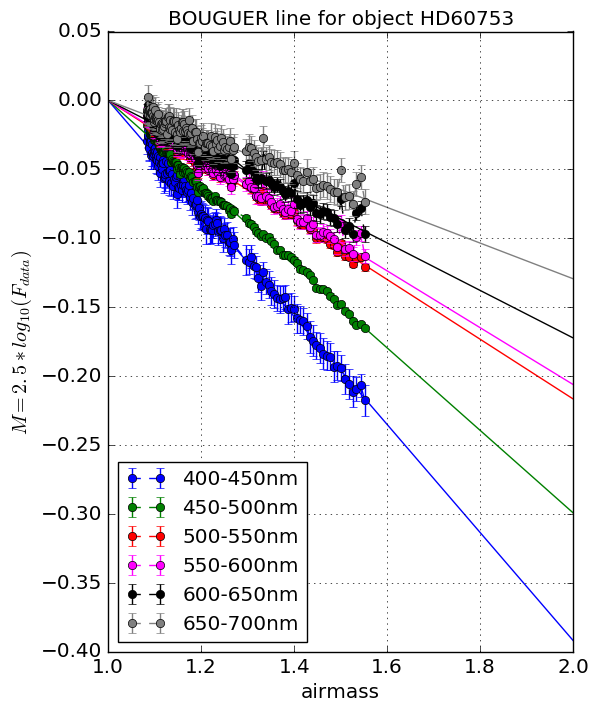

In [78]:
fitparamtruebouguer,popt_truebouguer,perr_truebouguer = ShowTrueBouguer(all_selected_wl,all_selected_dataspectrum,all_airmass)

In [79]:
truncpopt_truebouguer=np.trunc(np.array(popt_truebouguer)*10000)/10000
truncperr_truebouguer=np.trunc(np.array(perr_truebouguer)*10000)/10000

In [80]:
table = ListTable()
table.append(["slope","error"])
for idd in range(0,6):
    table.append([truncpopt_truebouguer[idd][0],truncperr_truebouguer[idd][0]])
table

[['slope', 'error'],
 [-0.39379999999999998, 0.0028999999999999998],
 [-0.29859999999999998, 0.0018],
 [-0.216, 0.0018],
 [-0.20619999999999999, 0.0027000000000000001],
 [-0.1691, 0.0030999999999999999],
 [-0.129, 0.0028999999999999998]]

In [81]:
np.array(popt_truebouguer)[:,0]

array([-0.39382785, -0.2986863 , -0.21600352, -0.20626616, -0.16915054,
       -0.12904401])

## Fit Rayleigh Scattering

In [82]:
def FuncRayleigh(x,a):
    return a*(400/x)**4/(1-0.0752*(400./x)**2)

In [83]:
def PlotRayleigh(thepopt,theperr):
    X= [425.,475.,525.,575.,625.,675.]
    Y= np.array(thepopt)[:,0]
    EY=np.array(theperr)[:,0]*10
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(X,Y,yerr=EY,fmt='o',color='red')
    
    title="Slope of BOUGUER line vs wavelength for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("slope/airmass (mag)")
    ax.grid(True)
    
    
    popt, pcov = curve_fit(FuncRayleigh,X,Y,sigma=EY)
    perr = np.sqrt(np.diag(pcov))
    xfit=np.linspace(400.,700.0,50)
    yfit=FuncRayleigh(xfit,popt[0])
    plt.plot(xfit,yfit)
    
    figfilename=os.path.join(dir_top_images,'fitrayleighwithbouguer.pdf')
    plt.savefig(figfilename)
    
    print popt[0] ,' at 400 nm'

-0.556120105186  at 400 nm


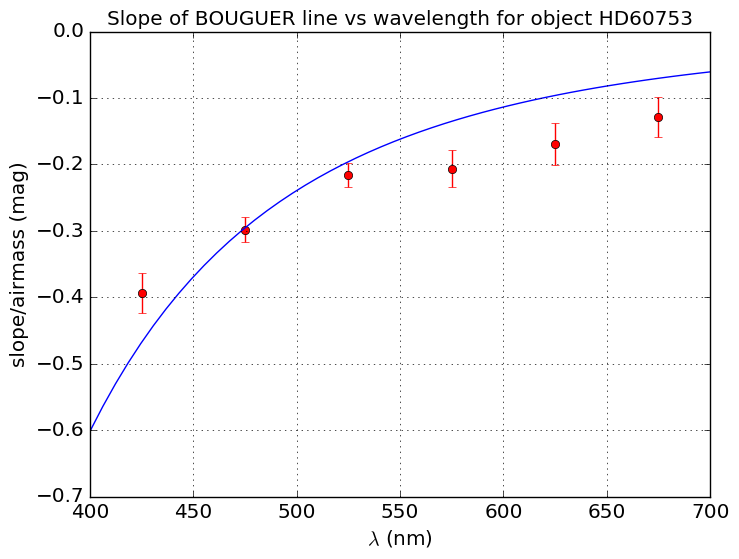

In [84]:
PlotRayleigh(popt_truebouguer,perr_truebouguer)

#### Index airmass min

In [85]:
all_airmass

[1.084,
 1.085,
 1.086,
 1.086,
 1.087,
 1.088,
 1.089,
 1.09,
 1.091,
 1.092,
 1.093,
 1.094,
 1.095,
 1.096,
 1.097,
 1.098,
 1.099,
 1.1,
 1.101,
 1.102,
 1.103,
 1.105,
 1.106,
 1.107,
 1.108,
 1.11,
 1.111,
 1.112,
 1.114,
 1.115,
 1.116,
 1.118,
 1.119,
 1.121,
 1.122,
 1.123,
 1.125,
 1.126,
 1.128,
 1.13,
 1.131,
 1.133,
 1.134,
 1.136,
 1.138,
 1.14,
 1.141,
 1.143,
 1.145,
 1.147,
 1.148,
 1.15,
 1.152,
 1.154,
 1.156,
 1.158,
 1.16,
 1.162,
 1.164,
 1.166,
 1.168,
 1.17,
 1.172,
 1.174,
 1.177,
 1.179,
 1.181,
 1.183,
 1.186,
 1.188,
 1.19,
 1.193,
 1.195,
 1.198,
 1.2,
 1.202,
 1.205,
 1.208,
 1.21,
 1.213,
 1.215,
 1.218,
 1.221,
 1.223,
 1.226,
 1.229,
 1.232,
 1.235,
 1.237,
 1.24,
 1.243,
 1.246,
 1.249,
 1.252,
 1.255,
 1.259,
 1.262,
 1.265,
 1.268,
 1.271,
 1.297,
 1.302,
 1.307,
 1.313,
 1.318,
 1.323,
 1.329,
 1.334,
 1.34,
 1.345,
 1.351,
 1.357,
 1.363,
 1.369,
 1.375,
 1.381,
 1.387,
 1.394,
 1.4,
 1.407,
 1.413,
 1.42,
 1.427,
 1.434,
 1.441,
 1.448,
 1.455,
 1

In [86]:
index_airmassmin=0

In [87]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idx : the index of minimum airmass
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
    
    #XMIN=350.
    #XMAX=800.
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    
    
    
    #interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    interpol_ratio=interp1d(thewl[idx],ratio_sel0)
    
    #wlcutmax=all_rightspectra_wl[idx].max()-1.
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    #selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    selectedindexes0=np.where(np.logical_and(thewl[idx]>wlcutmin, thewl[idx]<wlcutmax))
    
    #sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    sel_wl0=thewl[idx][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idx]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        zam=all_airmass[index]
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        #selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        selectedindexes=np.where(np.logical_and(thewl[index]>wlcutmin, thewl[index]<wlcutmax))     
        
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=thewl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimRRatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam


### Return the ratio

minimum airmass zmin =  1.084


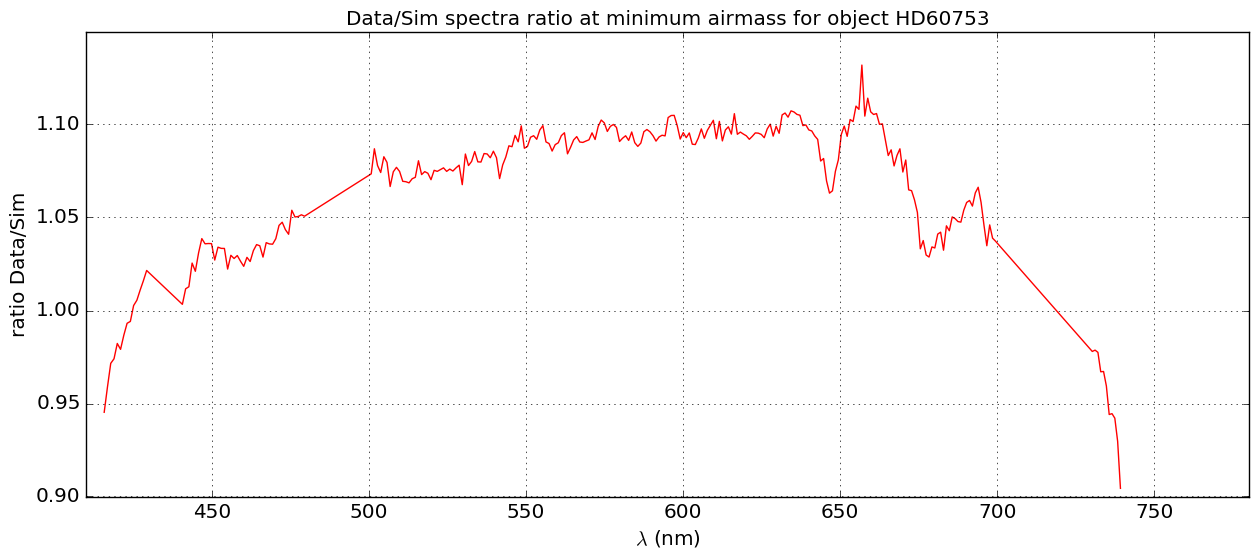

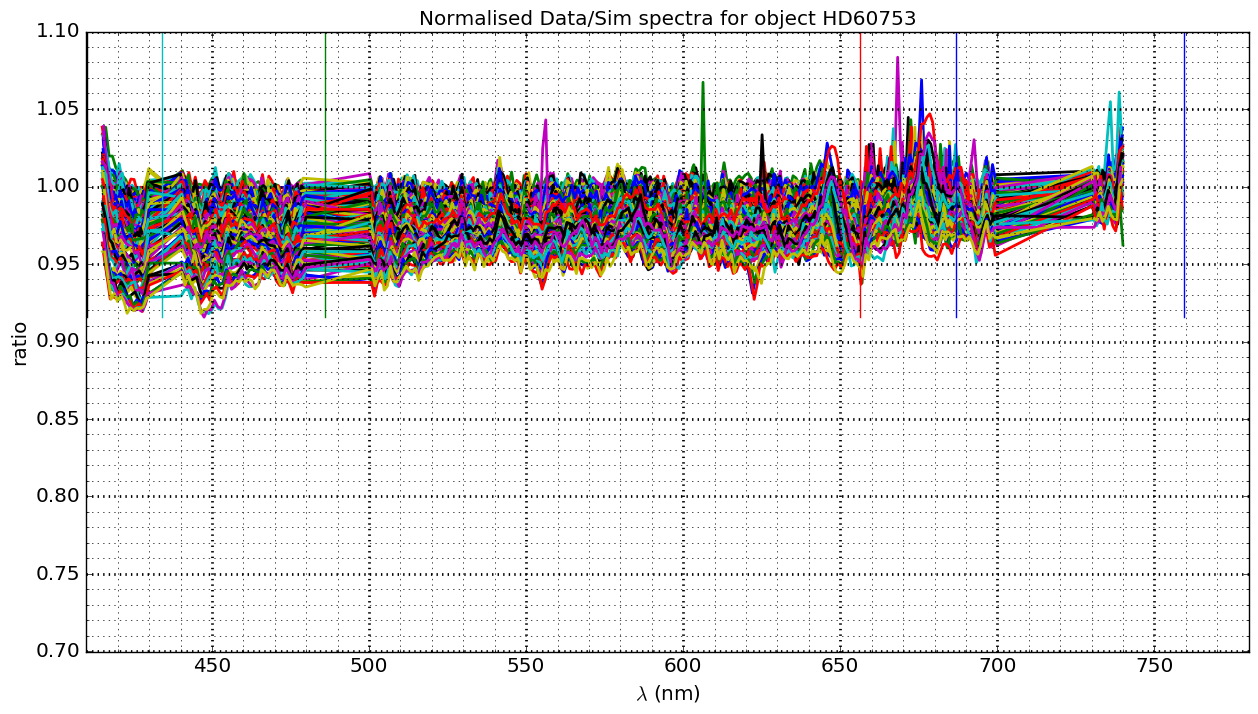

In [88]:
all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut=ShowRatioSpectraNorm(index_airmassmin,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [89]:
#all_ratiowl_full,all_ratioratio_full,all_dzam_full=ShowRatioSpectraNorm(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

## Bouguer Law

In [90]:
def ShowModifBouguer(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])  
    
    #ax.plot(all_z,all_log10R1vsZ,'o-',label=labels[0])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE1.pdf')
    plt.savefig(figfilename)
    

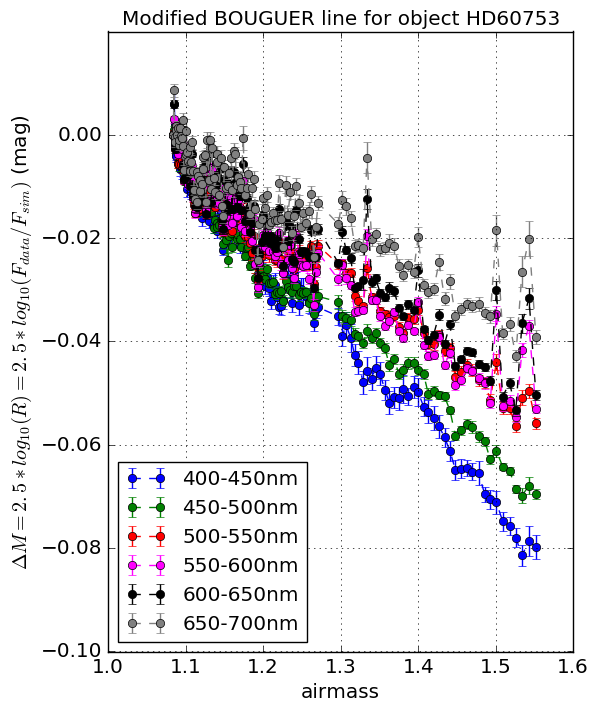

In [91]:
ShowModifBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [92]:
def ShowModifBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer2:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1))
            all_log10R2vsZE.append(np.std(all_log10R2))
            all_log10R3vsZE.append(np.std(all_log10R3))
            all_log10R4vsZE.append(np.std(all_log10R4))
            all_log10R5vsZE.append(np.std(all_log10R5))
            all_log10R6vsZE.append(np.std(all_log10R6))
        
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER curve for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE2.pdf')
    plt.savefig(figfilename)
    

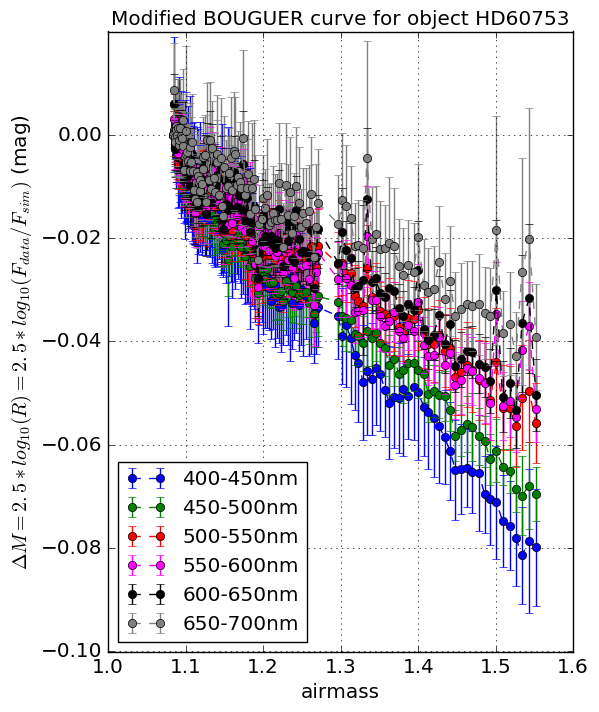

In [93]:
ShowModifBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [94]:
def SimpleLinearFitBouguer(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer:
    
    """
    
    ZCUT=1.3
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    fitparam1 = []
    fitparam2 = []
    y1fit = []
    y2fit = []
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    # loop on ratio
    #---------------
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
                
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
            
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
            
            if(thez<=ZCUT):  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
    
    
    x1=np.array(all_z1) 
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ1)
        elif iband ==1:
            y=np.array(all_log10R2vsZ1)
        elif iband==2:
            y=np.array(all_log10R3vsZ1)
        elif iband ==3:
            y=np.array(all_log10R4vsZ1) 
        elif iband==4:
            y=np.array(all_log10R5vsZ1)
        elif iband ==5:
            y=np.array(all_log10R6vsZ1) 
            
        z1 = np.polyfit(x1, y, 1)
        fitparam1.append(z1)    
        p1 = np.poly1d(z1)
        yfit=p1(x1fit)
        y1fit.append(yfit)
        
    x2=np.array(all_z2)
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ2)
        elif iband ==1:
            y=np.array(all_log10R2vsZ2)
        elif iband==2:
            y=np.array(all_log10R3vsZ2)
        elif iband ==3:
            y=np.array(all_log10R4vsZ2) 
        elif iband==4:
            y=np.array(all_log10R5vsZ2)
        elif iband ==5:
            y=np.array(all_log10R6vsZ2)            
        z2 = np.polyfit(x2, y, 1)
        fitparam2.append(z2)    
        p2 = np.poly1d(z2)
        yfit=p2(x2fit)
        y2fit.append(yfit)
                
    xfit=np.append(x1fit,x2fit)
    
    yfit=np.append(y1fit[0],y2fit[0])
    yfit=yfit-yfit[0] 
    ax.plot(xfit,yfit,'b-',lw=2,label=labels[0])
    
     
    yfit=np.append(y1fit[1],y2fit[1])
    yfit=yfit-yfit[1] 
    ax.plot(xfit,yfit,'r-',lw=2,label=labels[1])
    
    yfit=np.append(y1fit[2],y2fit[2])
    yfit=yfit-yfit[2] 
    ax.plot(xfit,yfit,'g-',lw=2,label=labels[2])
    
    yfit=np.append(y1fit[3],y2fit[3])
    yfit=yfit-yfit[3] 
    ax.plot(xfit,yfit,'k-',lw=2,label=labels[3])
    
    yfit=np.append(y1fit[4],y2fit[4])
    yfit=yfit-yfit[4] 
    ax.plot(xfit,yfit,'c-',lw=2,label=labels[4])
    
    yfit=np.append(y1fit[5],y2fit[5])
    yfit=yfit-yfit[5] 
    ax.plot(xfit,yfit,'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,np.append(y1fit[1],y2fit[1]),'r-',lw=2,label=labels[1])
    #ax.plot(xfit,np.append(y1fit[2],y2fit[2]),'g-',lw=2,label=labels[2])
    #ax.plot(xfit,np.append(y1fit[3],y2fit[3]),'k-',lw=2,label=labels[3])
    #ax.plot(xfit,np.append(y1fit[4],y2fit[4]),'c-',lw=2,label=labels[4])
    #ax.plot(xfit,np.append(y1fit[5],y2fit[5]),'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,y1fit[2],'g-',label=labels[2])
    #ax.plot(xfit,y1fit[3],'k-',label=labels[3])
    #ax.plot(xfit,y1fit[4],'c-',label=labels[4])
    #ax.plot(xfit,y1fit[5],'y-',label=labels[5])
    
    #ax.plot(x2fit,y2fit[0],'b-')
    #ax.plot(x2fit,y2fit[1],'r-')
    #ax.plot(x2fit,y2fit[2],'g-')
    #ax.plot(x2fit,y2fit[3],'k-')
    #ax.plot(x2fit,y2fit[4],'c-')
    #ax.plot(x2fit,y2fit[5],'y-')
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Simple Fit BOUGUER lines for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'fitbougher1.pdf')
    plt.savefig(figfilename)
    return np.array(fitparam1),np.array(fitparam2)
    

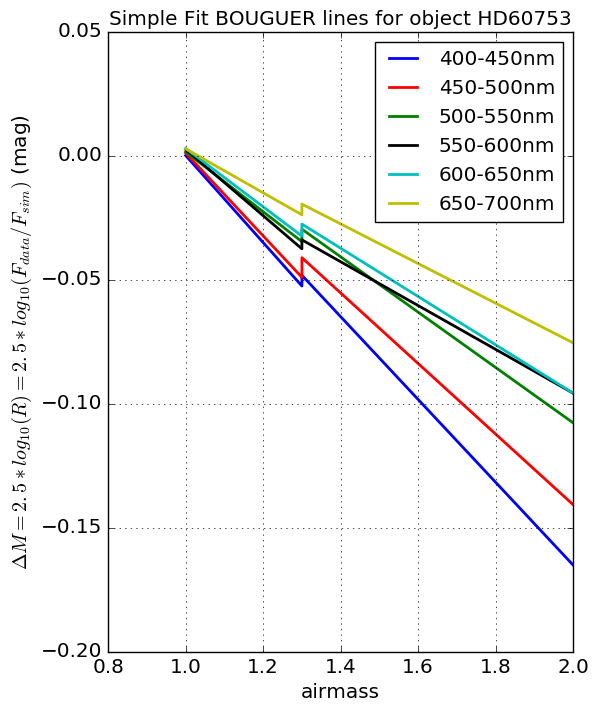

In [95]:
fitparam1_cut,fitparam2_cut=SimpleLinearFitBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

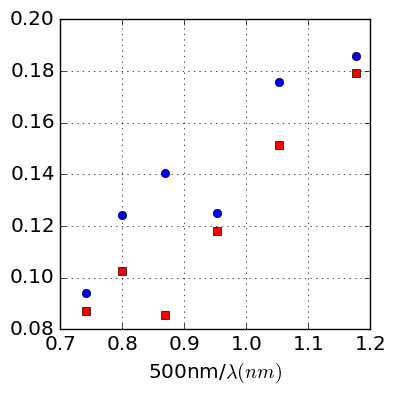

In [96]:
WLarr=np.array([425.,475.,525.,575.,625.,675.])
plt.plot(500/WLarr,fitparam1_cut[:,1] ,'o',color='blue')
plt.plot(500/WLarr,fitparam2_cut[:,1] ,'s',color='red')
plt.grid(True)
plt.xlabel("500nm/$\lambda (nm)$")

In [97]:
# import numpy.polynomial.polynomial.polyfit as polyfitw

In [98]:
from scipy.optimize import curve_fit

In [99]:
#def bougline(x, a, b):
#    return a*x + b

In [100]:
def FitABouguerLine(thex,they,theey):
    
    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theey)
    z = np.polyfit(x,y, 1)    
    popt, pcov = curve_fit(bougline,x,y,p0=z,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [101]:
def FitBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer2:
    
    """
    
    ZCUT=1.3
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_log10R1vsZ1E = []
    all_log10R2vsZ1E = []
    all_log10R3vsZ1E = []
    all_log10R4vsZ1E = []
    all_log10R5vsZ1E = []
    all_log10R6vsZ1E = []
    
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    all_log10R1vsZ2E = []
    all_log10R2vsZ2E = []
    all_log10R3vsZ2E = []
    all_log10R4vsZ2E = []
    all_log10R5vsZ2E = []
    all_log10R6vsZ2E = []
    
    fitparam1 = []
    fitparam2 = []
    
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    
    
    # loop on ratio to compute arerage and error points, that is to say, on the airmass z
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0: 
        
            thez=thedzam[index]+zmin
            
           
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
           
            # separate according the conditions depending on Z
            #--------------------------------------------------
            if thez<=ZCUT:  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
                
                all_log10R1vsZ1E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ1E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ1E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ1E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ1E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ1E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
                
                all_log10R1vsZ2E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ2E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ2E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ2E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ2E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ2E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
   
    
    # plot the points    
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='o',color='grey',label=labels[5])
    
    
    
    ## Now does the fit for z<ZCUT
    
    all_z1=np.array(all_z1)
    all_z2=np.array(all_z2)
    all_log10R1vsZ1=np.array(all_log10R1vsZ1)
    all_log10R2vsZ1=np.array(all_log10R2vsZ1)
    all_log10R3vsZ1=np.array(all_log10R3vsZ1)
    all_log10R4vsZ1=np.array(all_log10R4vsZ1)
    all_log10R5vsZ1=np.array(all_log10R5vsZ1)
    all_log10R6vsZ1=np.array(all_log10R6vsZ1)
    
    all_log10R1vsZ1E=np.array(all_log10R1vsZ1E)
    all_log10R2vsZ1E=np.array(all_log10R2vsZ1E)
    all_log10R3vsZ1E=np.array(all_log10R3vsZ1E)
    all_log10R4vsZ1E=np.array(all_log10R4vsZ1E)
    all_log10R5vsZ1E=np.array(all_log10R5vsZ1E)
    all_log10R6vsZ1E=np.array(all_log10R6vsZ1E)
    
    
    popt,perr=FitABouguerLine(all_z1,all_log10R1vsZ1,all_log10R1vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R2vsZ1,all_log10R2vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'g-',lw=2)
   
    
    popt,perr=FitABouguerLine(all_z1,all_log10R3vsZ1,all_log10R3vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R4vsZ1,all_log10R4vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R5vsZ1,all_log10R5vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R6vsZ1,all_log10R6vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'-',color='grey',lw=2)
        
    popt,perr=FitABouguerLine(all_z2,all_log10R1vsZ2,all_log10R1vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R2vsZ2,all_log10R2vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'g-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R3vsZ2,all_log10R3vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R4vsZ2,all_log10R4vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R5vsZ2,all_log10R5vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R6vsZ2,all_log10R6vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'-',color='grey',lw=2)
    
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    #ax.set_xlim(1.3,2)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_fitbougherE1.pdf')
    plt.savefig(figfilename)
    

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


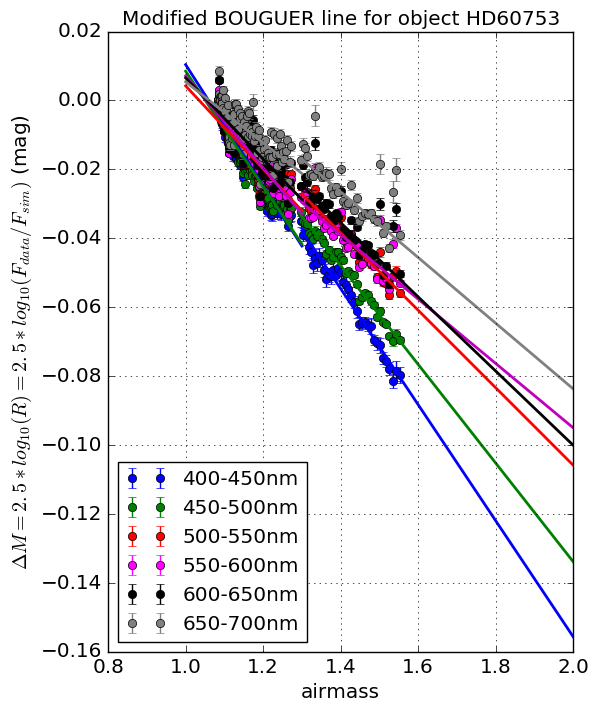

In [102]:
FitBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

## Fit Ratio

In [103]:
def FitRatio(all_ratiowl,all_ratioratio,all_dzam,figtitle='Normalised Data/Sim spectra for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=1.1
    YMIN=0.7
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dz=all_dzam[index]
        
        if all_expo[index]>0 and dz>0 : 
            x=all_ratiowl[index]
            y=all_ratioratio[index]
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
        
           
            ax.plot(xfit,yfit,'-',lw=1)
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitLinearDataSimNormDataSimRRatio.pdf')
    plt.savefig(figfilename)
    
    return np.array(fitparam)

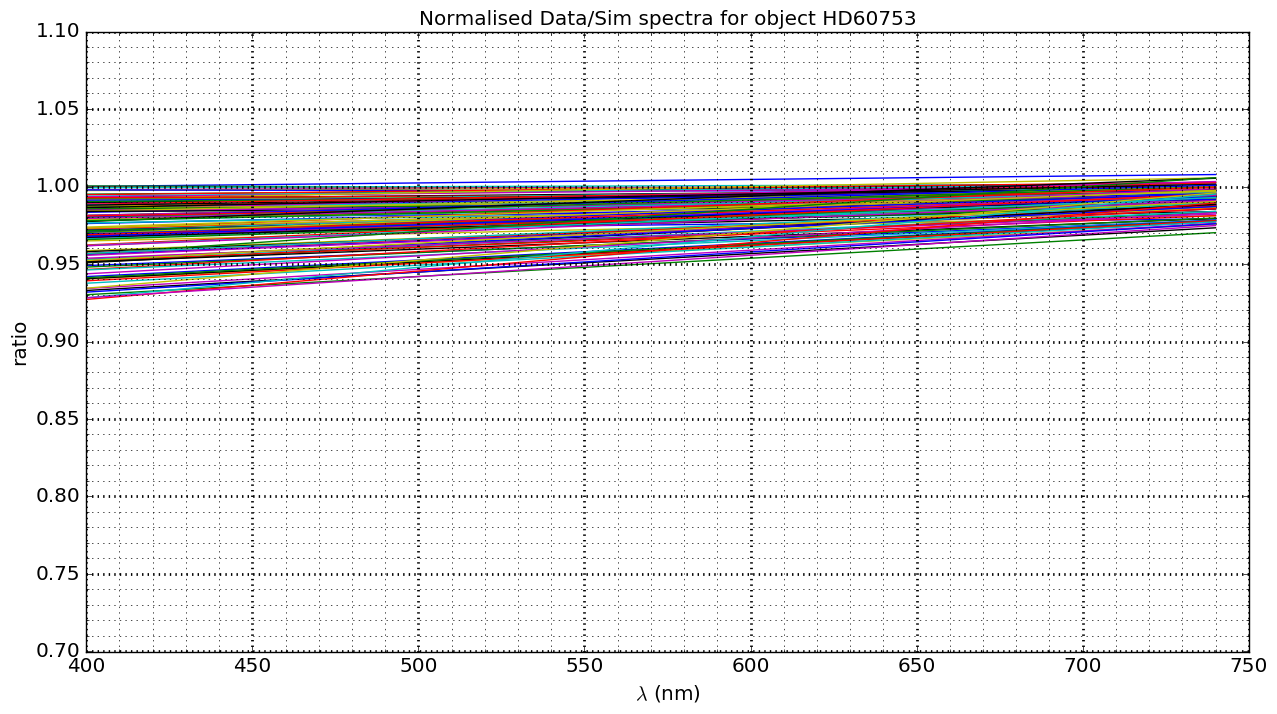

In [104]:
fitparam_cut=FitRatio(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

# New U ratio
================

## Definition of U ratio
=============================
$$
U(\lambda, z-z_{min}) = \frac{ \frac{T_{data}(z)}{T_{sim}(z)}}{ \frac{T_{data}(z_{min})}{T_{sim}(z_{min})}}= 
\exp \left( (z-z_{min}) \times \left(\tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha \right) \right)
$$


by calculating the following ratio $W(\lambda)$
$$
W(\lambda) = \frac{- \ln R(\lambda,z-z_{min})}{(z-z_{min})} = \tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha 
$$


From the series of images, we calculate $W(\lambda)$

### find the correspondence airmass-index

In [105]:
NBAIRMASS=len(all_airmass)
zipped=zip(range(NBAIRMASS),all_airmass)
print zipped

[(0, 1.084), (1, 1.085), (2, 1.086), (3, 1.086), (4, 1.087), (5, 1.088), (6, 1.089), (7, 1.09), (8, 1.091), (9, 1.092), (10, 1.093), (11, 1.094), (12, 1.095), (13, 1.096), (14, 1.097), (15, 1.098), (16, 1.099), (17, 1.1), (18, 1.101), (19, 1.102), (20, 1.103), (21, 1.105), (22, 1.106), (23, 1.107), (24, 1.108), (25, 1.11), (26, 1.111), (27, 1.112), (28, 1.114), (29, 1.115), (30, 1.116), (31, 1.118), (32, 1.119), (33, 1.121), (34, 1.122), (35, 1.123), (36, 1.125), (37, 1.126), (38, 1.128), (39, 1.13), (40, 1.131), (41, 1.133), (42, 1.134), (43, 1.136), (44, 1.138), (45, 1.14), (46, 1.141), (47, 1.143), (48, 1.145), (49, 1.147), (50, 1.148), (51, 1.15), (52, 1.152), (53, 1.154), (54, 1.156), (55, 1.158), (56, 1.16), (57, 1.162), (58, 1.164), (59, 1.166), (60, 1.168), (61, 1.17), (62, 1.172), (63, 1.174), (64, 1.177), (65, 1.179), (66, 1.181), (67, 1.183), (68, 1.186), (69, 1.188), (70, 1.19), (71, 1.193), (72, 1.195), (73, 1.198), (74, 1.2), (75, 1.202), (76, 1.205), (77, 1.208), (78, 1.

### defines the range where to compute the ratio ratio

In [106]:
idxnorm1=0
idxstart1=1
idxstop1=100

idxnorm2=101
idxstart2=102
idxstop2=138

In [107]:
def ExtractURatioSpectraNorm(idxnorm,idxstart,idxstop,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ExtractURatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idxnorm : the index of minimum airmass
    - idxstart : index to start the airmass loop
    - idxstop : index for stopping the airmass loop
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
  
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idxnorm]/thesimspec[idxnorm]
    
    
   
    interpol_ratio=interp1d(thewl[idxnorm],ratio_sel0)
    
    
    wlcutmin=XMIN
    wlcutmax=XMAX
    
        
    selectedindexes0=np.where(np.logical_and(thewl[idxnorm]>wlcutmin, thewl[idxnorm]<wlcutmax))
   
    sel_wl0=thewl[idxnorm][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idxnorm]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    #for index in np.arange(0,NBSPECTRA):
    for fullindex in np.arange(idxstart,idxstop+1):    
        
        index=fullindex-idxstart
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        # the current airmass
        zam=all_airmass[fullindex]
        
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        # select the ratio in the appropriate WL range
        selectedindexes=np.where(np.logical_and(thewl[fullindex]>wlcutmin, thewl[fullindex]<wlcutmax))     
        
        sel_data=thespectrum[fullindex][selectedindexes]
        sel_sim=thesimspec[fullindex][selectedindexes]
        sel_wl=thewl[fullindex][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[fullindex]>0:    ## Should always be the case now
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra U ratio for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimURatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam



minimum airmass zmin =  1.084


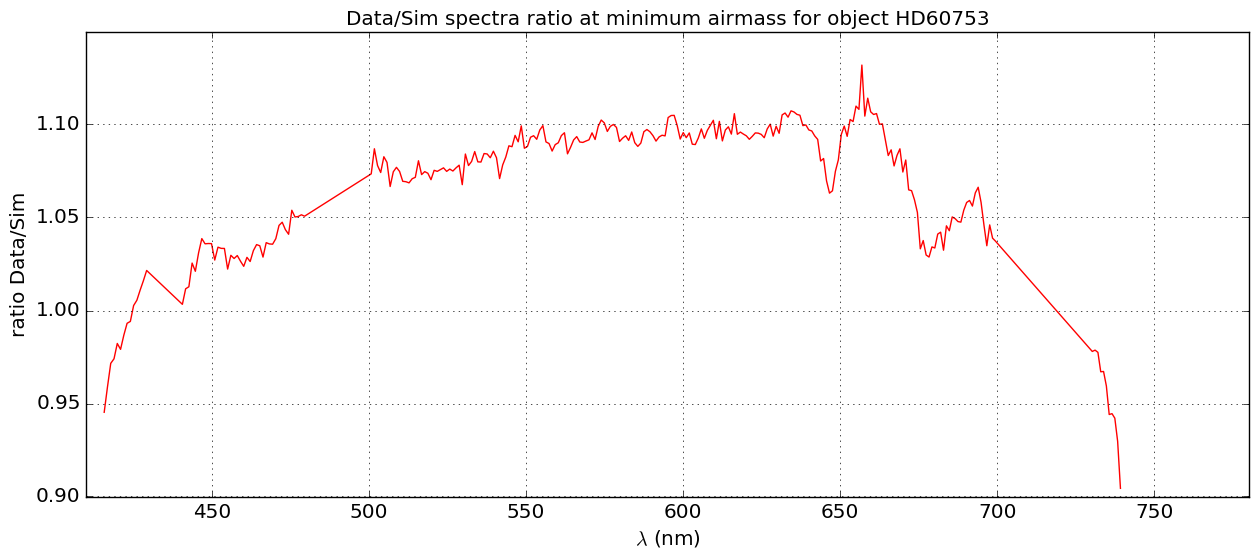

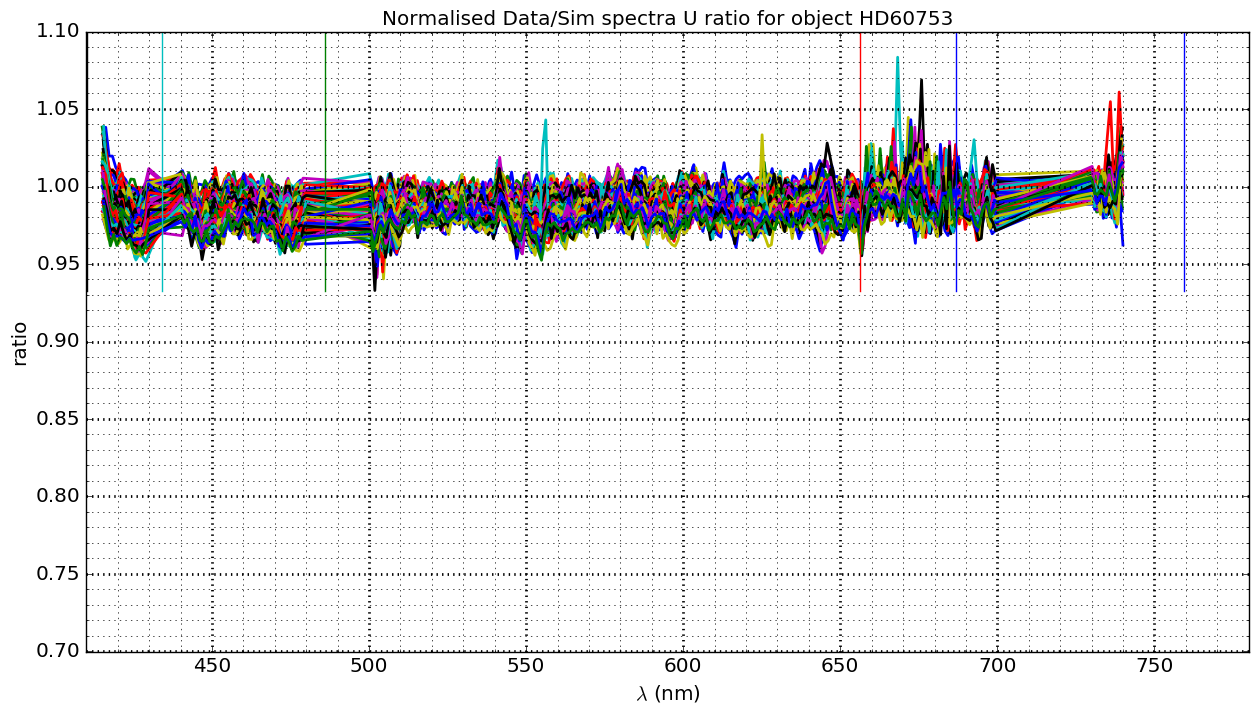

In [108]:
all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1=ExtractURatioSpectraNorm(idxnorm1,idxstart1,idxstop1,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

minimum airmass zmin =  1.302


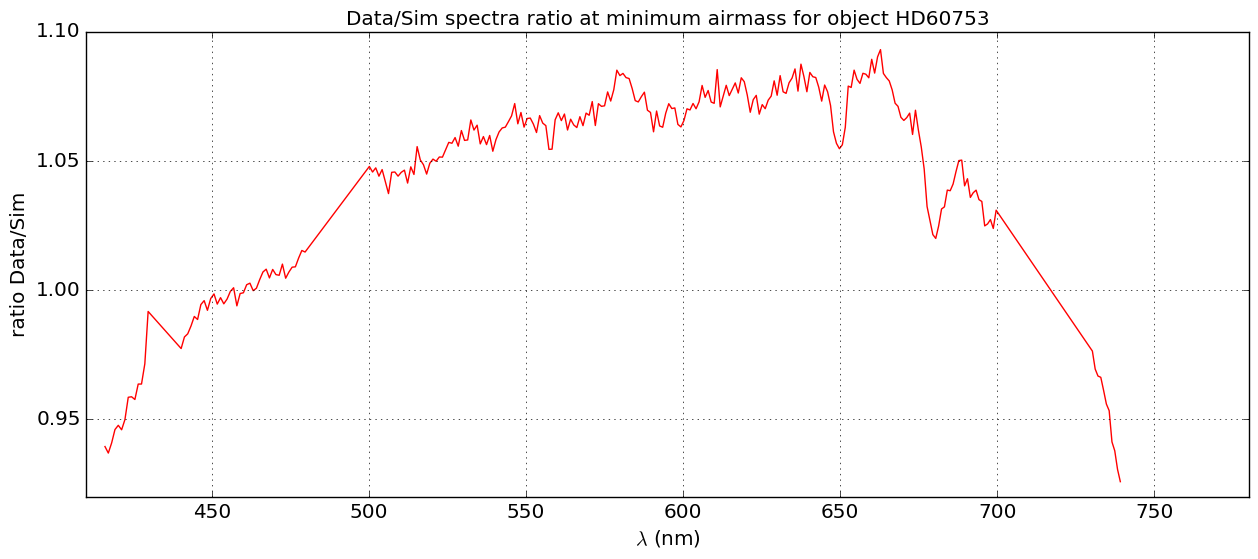

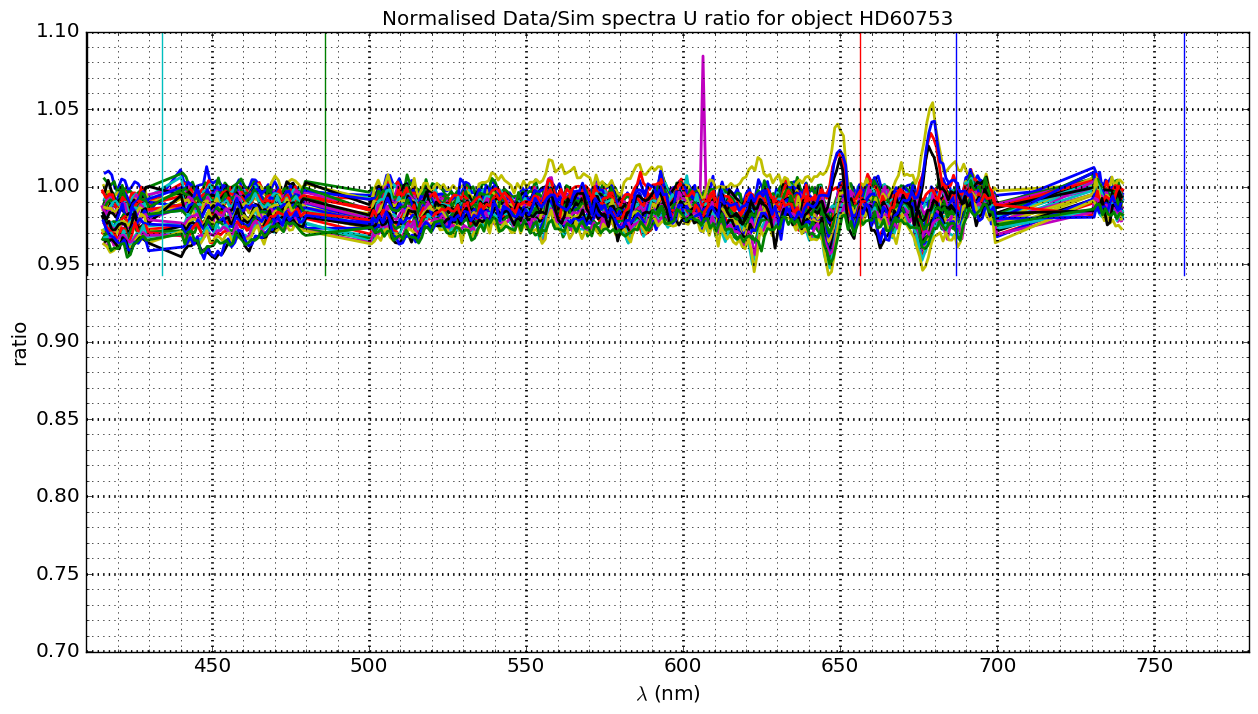

In [109]:
all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2=ExtractURatioSpectraNorm(idxnorm2,idxstart2,idxstop2,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [110]:
def PlotExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'Extinction1_Uratio.pdf')
    plt.savefig(figfilename)
   

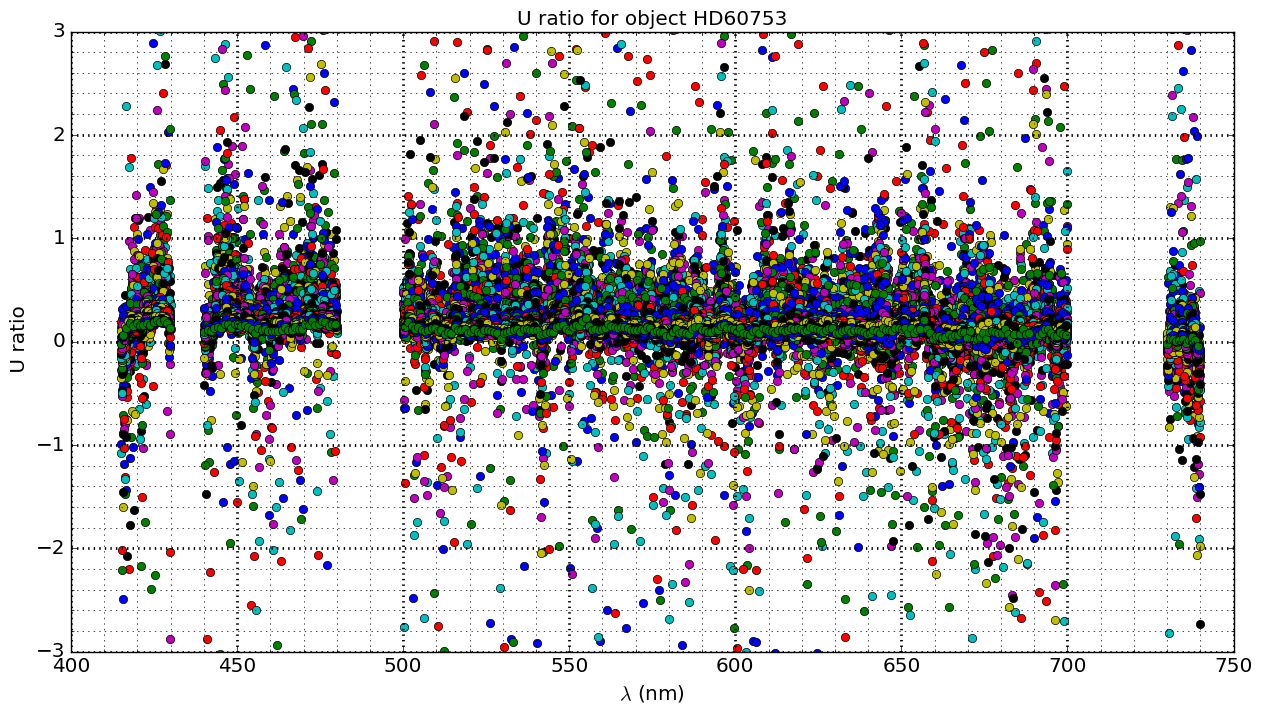

In [111]:
PlotExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

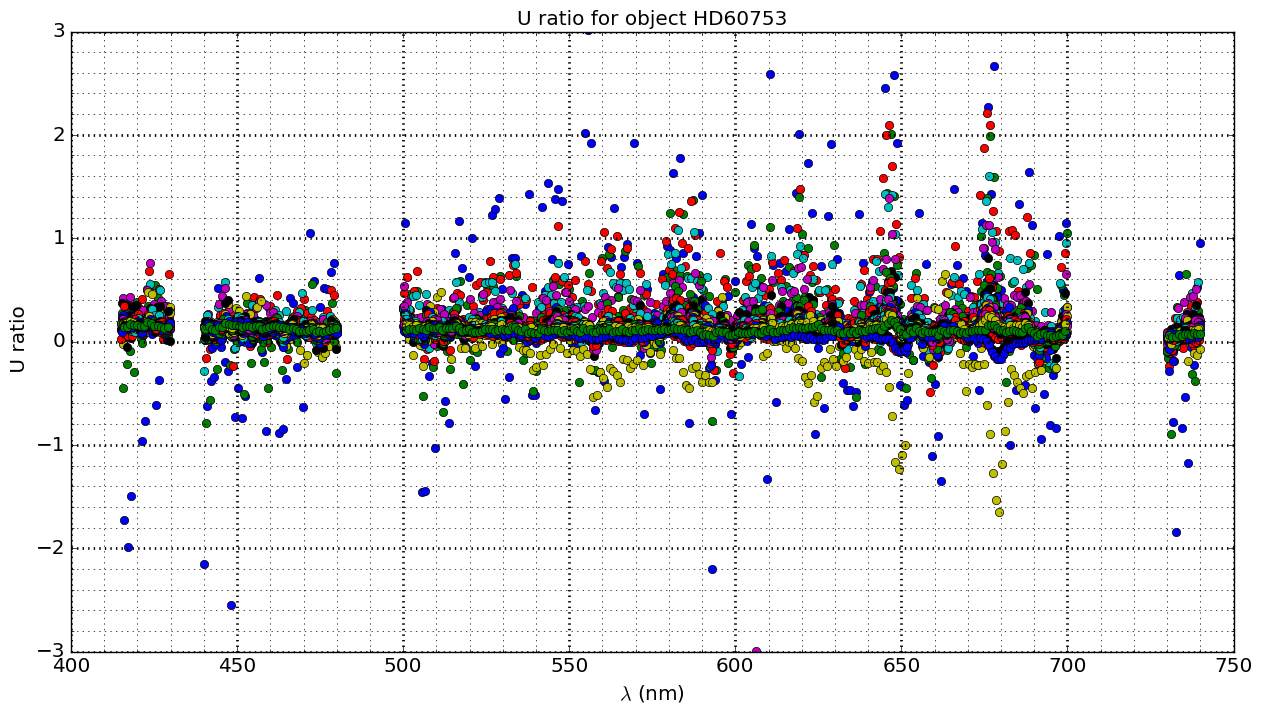

In [112]:
PlotExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [113]:
def PlotExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus 1/lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'Extinction2_Uratio.pdf')
    plt.savefig(figfilename)
    

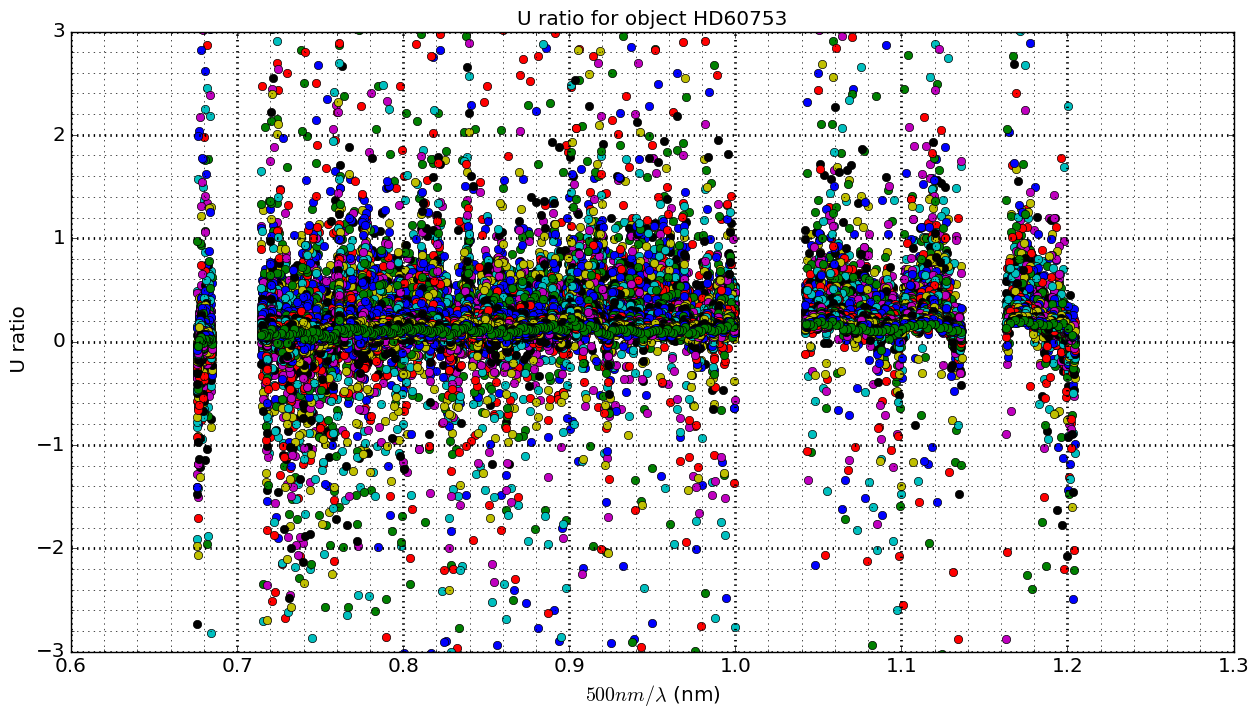

In [114]:
PlotExtinction2(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

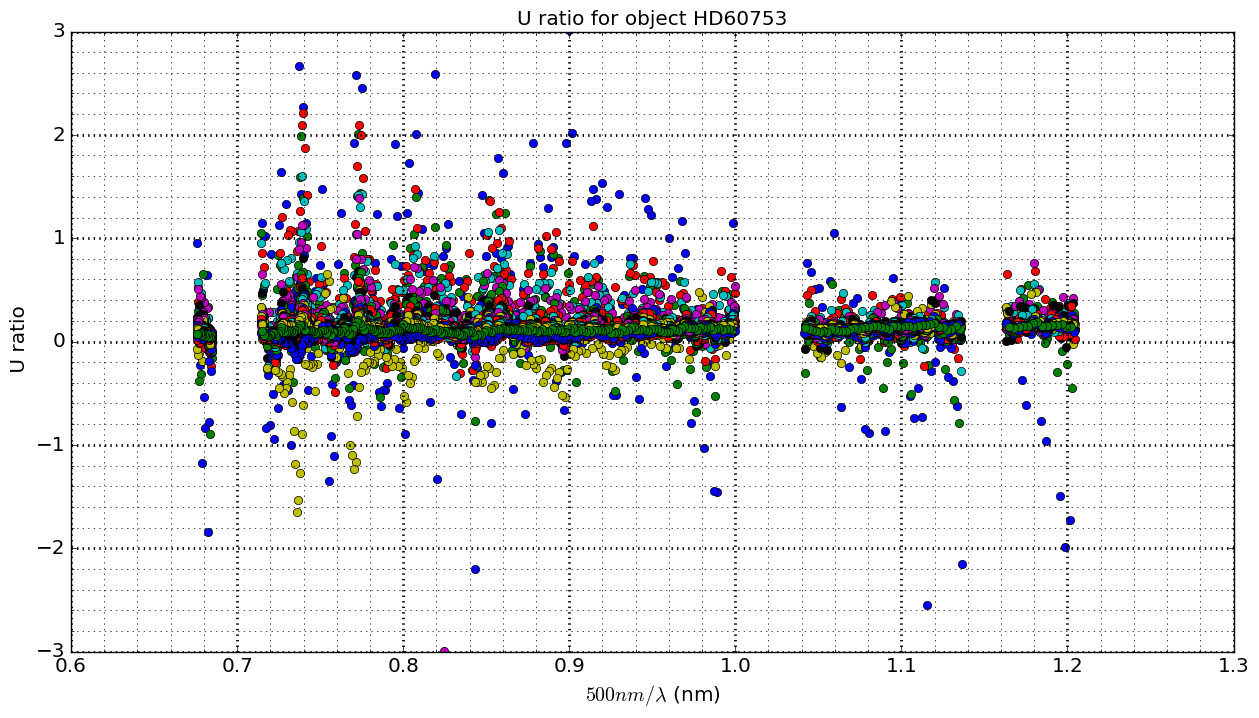

In [115]:
PlotExtinction2(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Linear fit of extinction

In [116]:
def LinearFitExtinction(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit U ratio for object {}'):
   
    NBRATIOS=len(all_ratioratio)
    
    print "NBRATIOS =",NBRATIOS
    
    XMIN=0.65
    XMAX=1.3
    YMAX=1
    YMIN=-1

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIOS):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
                        
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
         
            ax.plot(xfit,yfit,'-',lw=1)        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'FitLinearExtinction2_Uratio.pdf')
    plt.savefig(figfilename)
    
        
    return np.array(fitparam), all_dzrel
        

NBRATIOS = 100


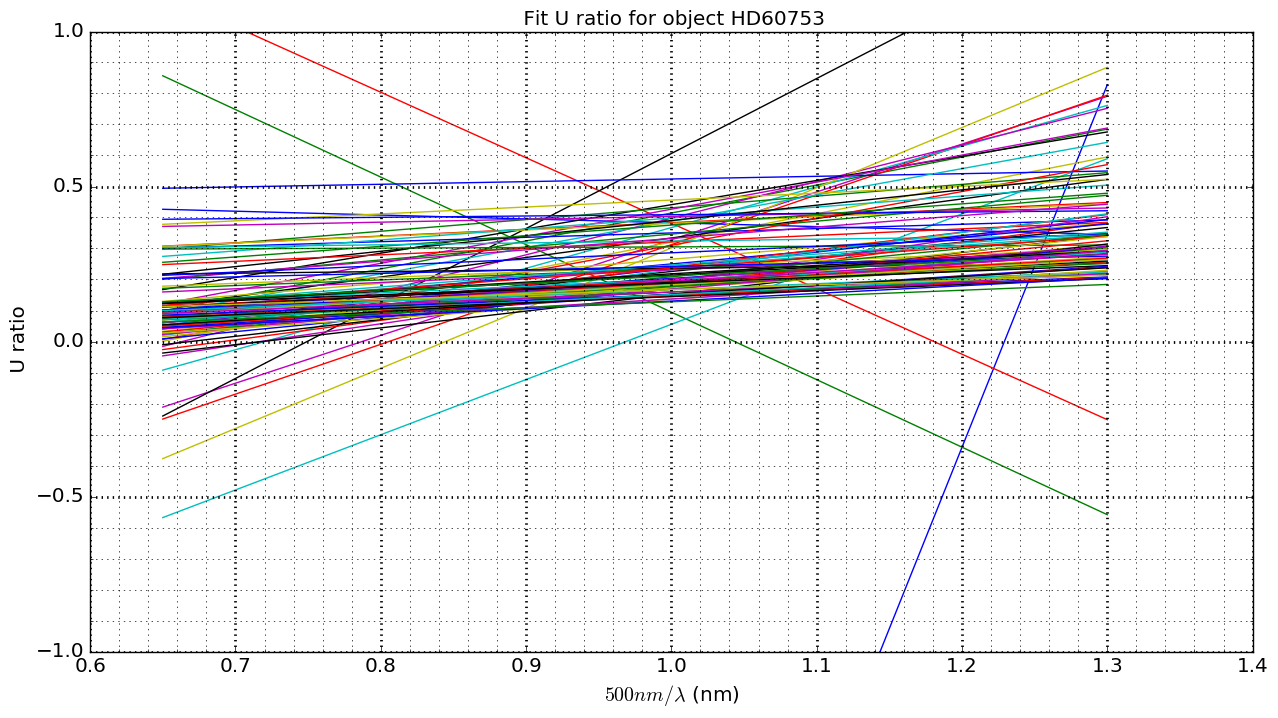

In [117]:
fitparam_cut1,all_dzrel_cut1=LinearFitExtinction(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

NBRATIOS = 37


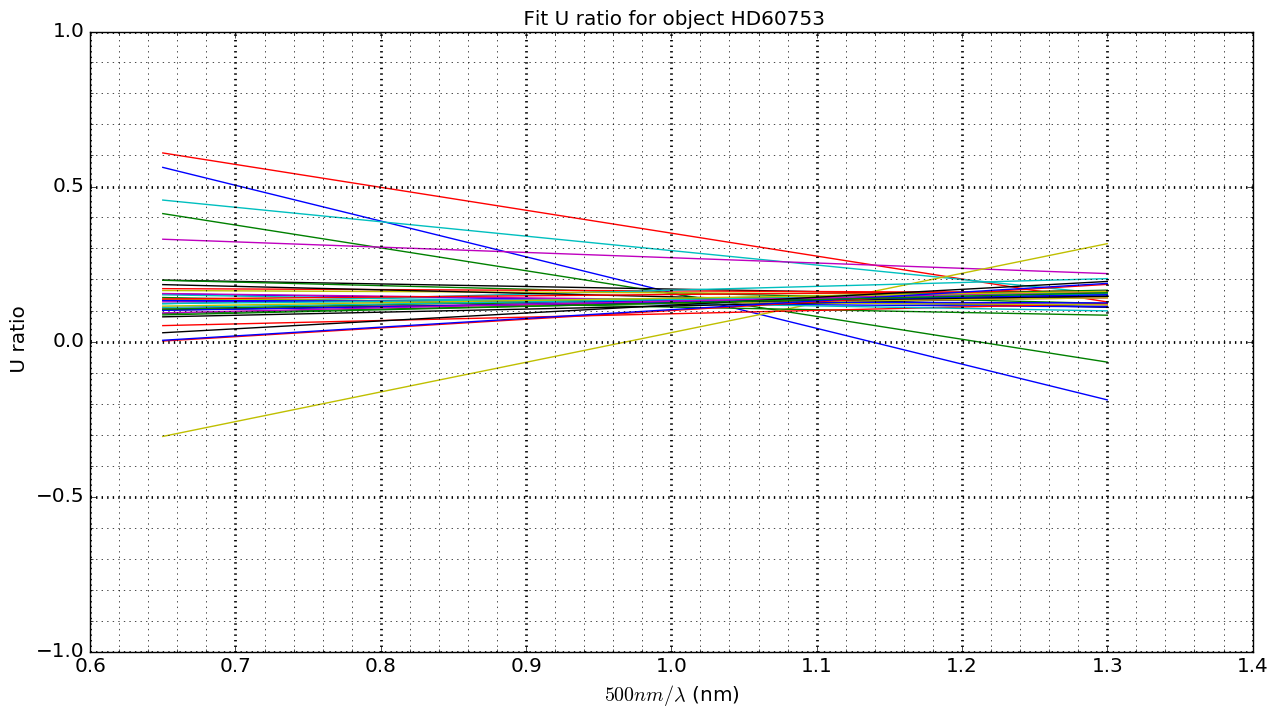

In [118]:
fitparam_cut2,all_dzrel_cut2=LinearFitExtinction(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Non linear fit of extinction

In [119]:
from scipy.optimize import curve_fit

In [120]:
def extinct(x, a, b,c):
    return a + b * x**c

In [121]:
def FitExtinct(thex,they):
    x=np.copy(thex)
    y=np.copy(they)
    z = np.polyfit(x,y, 1)
    z=np.append(z,1.)
    popt, pcov = curve_fit(extinct,x,y,p0=z)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [122]:
def NonLinearFitExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=0.65
    XMAX=1.3
    YMAX=0.5
    YMIN=-0.2

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            popt, perr = FitExtinct(x, y)
            chi2_vector=(y-extinct(x,popt[0],popt[1],popt[2]))**2
            chi2=np.average(chi2_vector)
            
            #print '------------------------------------'
            #print "a =", popt[0], "+/-", pcov[0,0]**0.5
            #print "b =", popt[1], "+/-", pcov[1,1]**0.5
            #print "c =", popt[2], "+/-", pcov[2,2]**0.5
            #print "chi2 =", chi2
                       
        
            fitoptparam.append(popt)  
            fitperr.append(perr)
            fitchi2.append(chi2)
            
            yfit=extinct(xfit,popt[0],popt[1],popt[2])
         
            if chi2 <0.003:              
                ax.plot(x,y,'o')
                ax.plot(xfit,yfit,'-',lw=2) 
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction1_Uratio.pdf')
    plt.savefig(figfilename)
   
        
    return np.array(fitoptparam), all_dzrel, fitperr,fitchi2
        

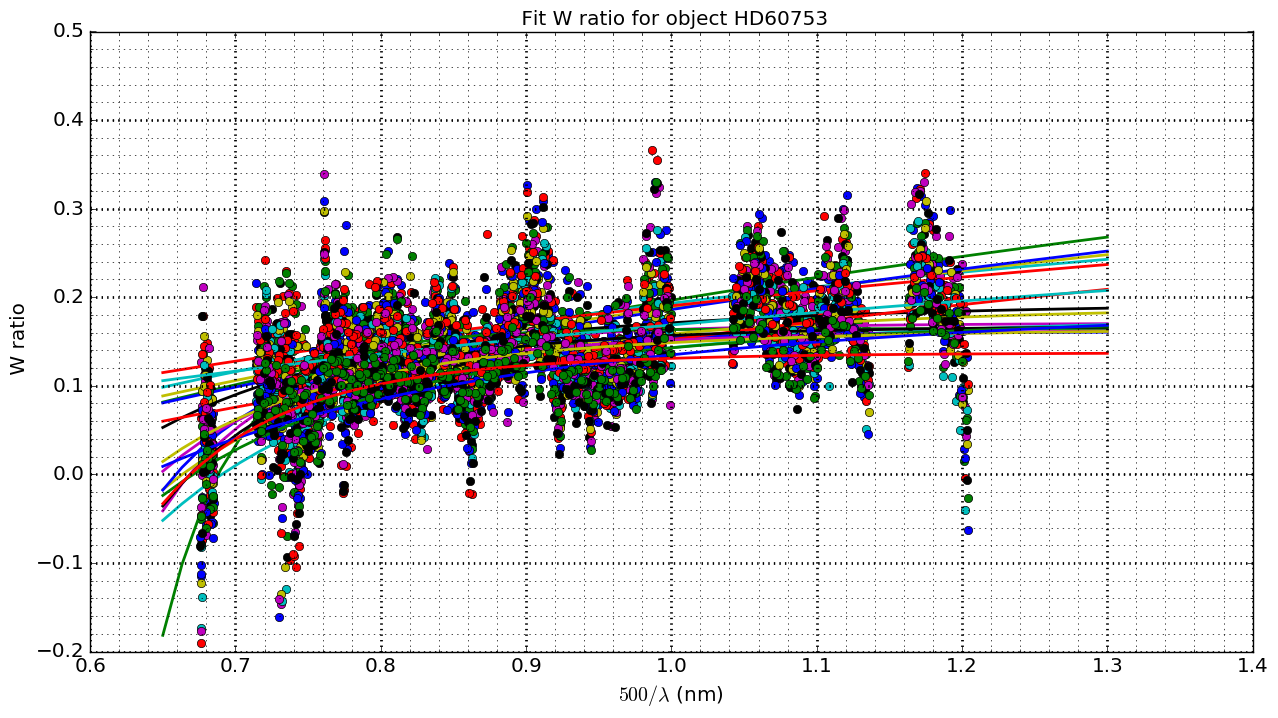

In [123]:
fitoptparam_cut1,all_dzrel_cut1,fitperr_cut1,fitchi2_cut1=NonLinearFitExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

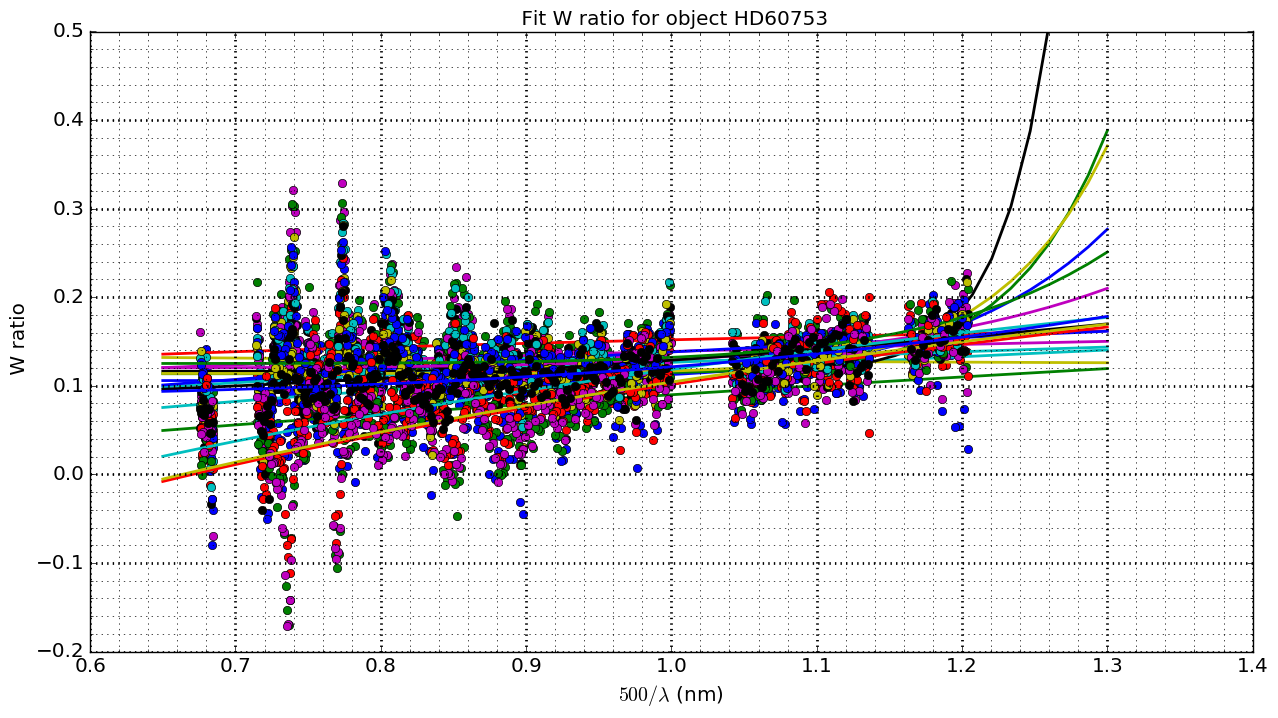

In [124]:
fitoptparam_cut2,all_dzrel_cut2,fitperr_cut2,fitchi2_cut2=NonLinearFitExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

## Component 1 : z < zcut
----------------------------------

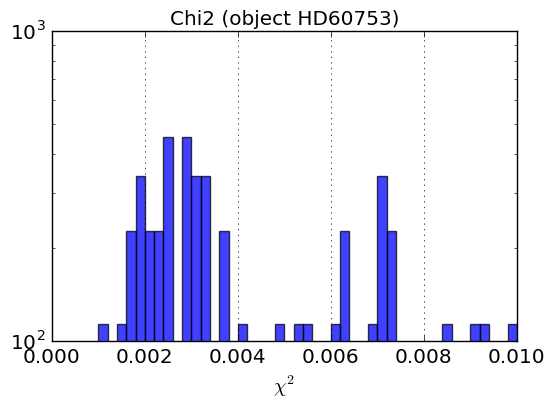

In [125]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut1, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

In [126]:
def GetMeanAndSigma(arr):
    themean=np.mean(arr)
    thevariance=np.var(arr)
    thesigma=np.sqrt(thevariance)
    newmean=np.trunc(themean*1000)/1000
    newsigma=np.trunc(thesigma*1000)/1000
    #newmean=np.round(themean,3)
    #newsigma=np.round(thesigma,3)
    #newmean=np.rint(themean*1000)/1000
    #newsigma=np.rint(thesigma*1000)/1000
    thevariation=newsigma/newmean
    thevaria=np.trunc(thevariation*100)
    return newmean,newsigma,thevaria

### grey attenuation

In [127]:
GetMeanAndSigma(fitoptparam_cut1[:,0])

(-6.1050000000000004, 24.843, -406.0)

In [128]:
print "median = ",np.median(fitoptparam_cut1[:,0])
print "average = ",np.average(fitoptparam_cut1[:,0])
print "std = ",np.std(fitoptparam_cut1[:,0])

median =  -0.0201609108654
average =  -6.10558430699
std =  24.8435010562


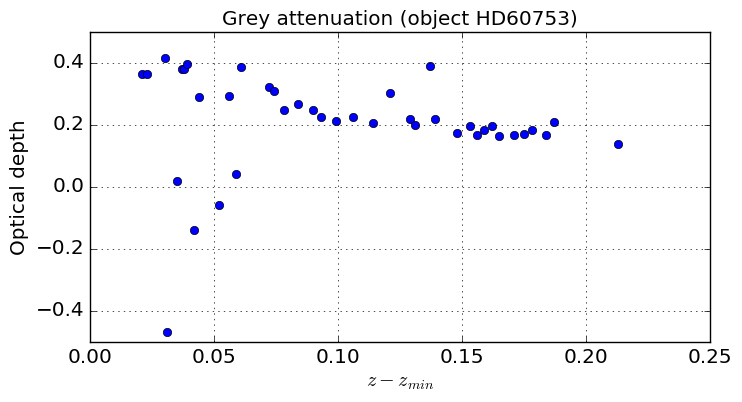

In [129]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut1[:,0]
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz1.pdf')
plt.savefig(figfilename)

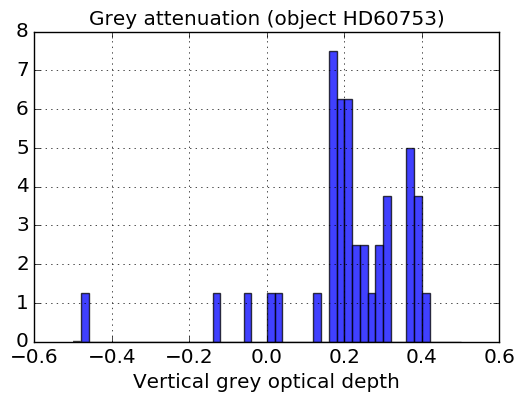

In [130]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto1.pdf')
plt.savefig(figfilename)

### Aerosols  

In [131]:
GetMeanAndSigma(fitoptparam_cut1[:,1])

(6.3339999999999996, 24.611000000000001, 388.0)

In [132]:
print "median = ",np.median(fitoptparam_cut1[:,1])
print "average = ",np.average(fitoptparam_cut1[:,1])
print "std = ",np.std(fitoptparam_cut1[:,1])

median =  0.307106520471
average =  6.33406228816
std =  24.6113507347


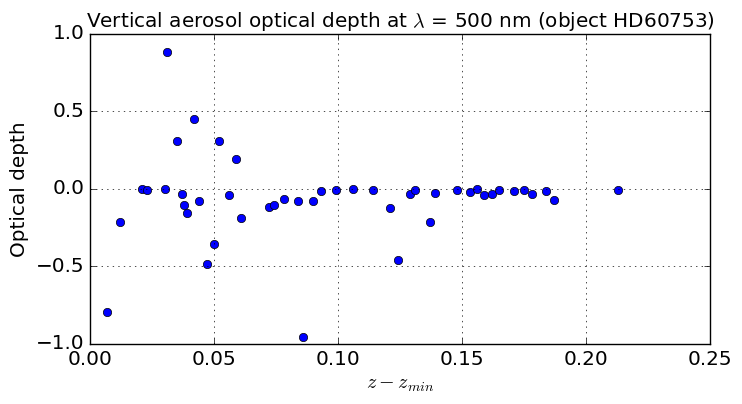

In [133]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz1.pdf')
plt.savefig(figfilename)

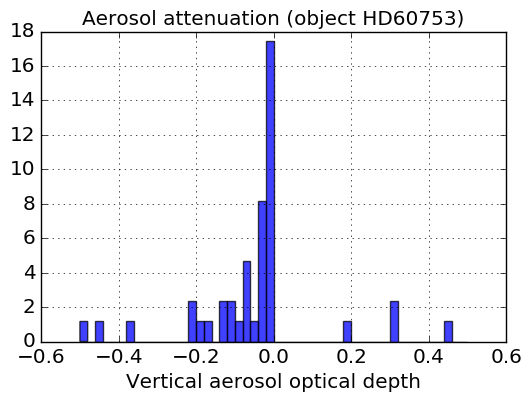

In [134]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto1.pdf')
plt.savefig(figfilename)

### Angstrom exponent

In [135]:
GetMeanAndSigma(fitoptparam_cut1[:,2])

(-2.0350000000000001, 3.4060000000000001, -167.0)

In [136]:
print "median = ",np.median(fitoptparam_cut1[:,2])
print "average = ",np.average(fitoptparam_cut1[:,2])
print "std = ",np.std(fitoptparam_cut1[:,2])

median =  0.027131745227
average =  -2.03525466401
std =  3.40676958116


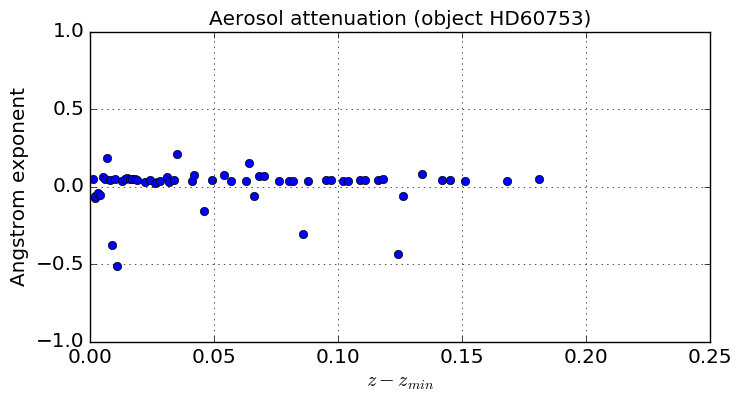

In [137]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz1.pdf')
plt.savefig(figfilename)

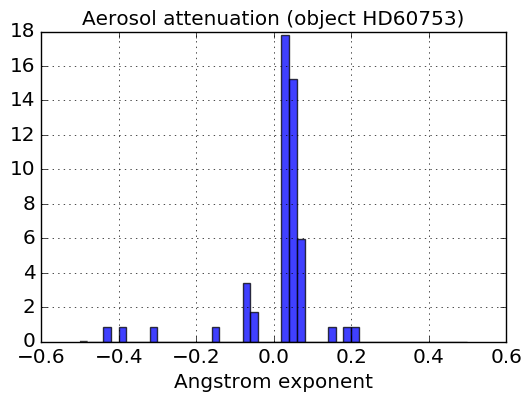

In [138]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto1.pdf')
plt.savefig(figfilename)

## Component 2 : z > zcut
----------------------------------

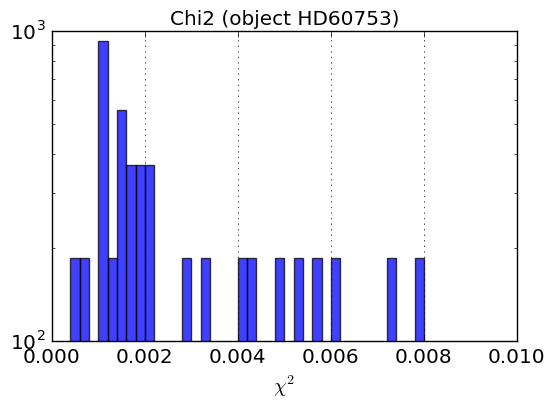

In [139]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut2, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

#### Grey attenuation

In [140]:
GetMeanAndSigma(fitoptparam_cut2[:,0])

(-0.98199999999999998, 4.7699999999999996, -485.0)

In [141]:
print "median = ",np.median(fitoptparam_cut2[:,0])
print "average = ",np.average(fitoptparam_cut2[:,0])
print "std = ",np.std(fitoptparam_cut2[:,0])


median =  -0.257124531046
average =  -0.982288167396
std =  4.77086985826


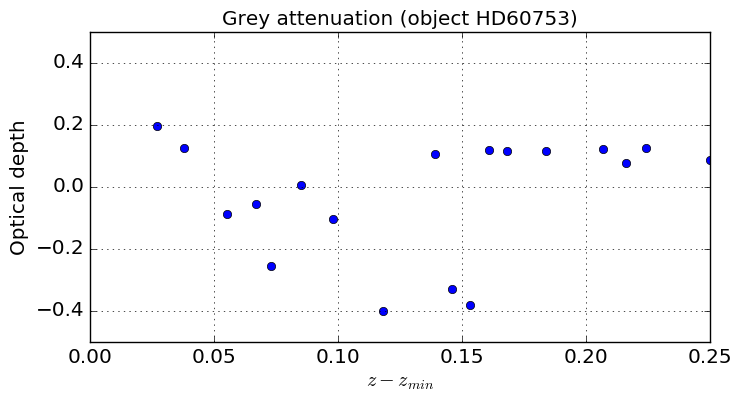

In [142]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut2[:,0]
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz2.pdf')
plt.savefig(figfilename)

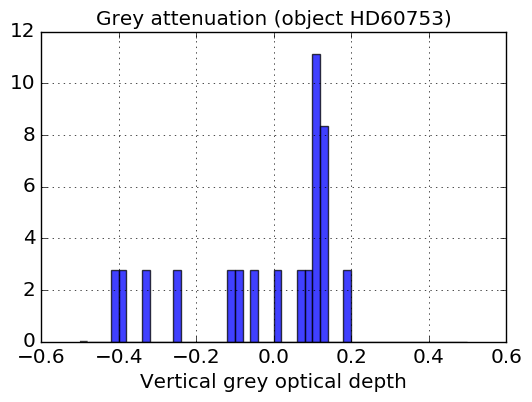

In [143]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto2.pdf')
plt.savefig(figfilename)

### Aerosols

In [144]:
GetMeanAndSigma(fitoptparam_cut2[:,1])

(1.125, 4.798, 426.0)

In [145]:
print "median = ",np.median(fitoptparam_cut2[:,1])
print "average = ",np.average(fitoptparam_cut2[:,1])
print "std = ",np.std(fitoptparam_cut2[:,1])

median =  0.41442420506
average =  1.12535991473
std =  4.79864469244


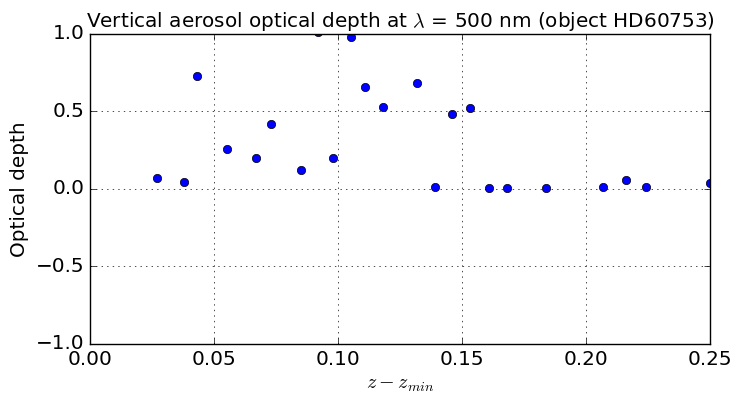

In [146]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz2.pdf')
plt.savefig(figfilename)

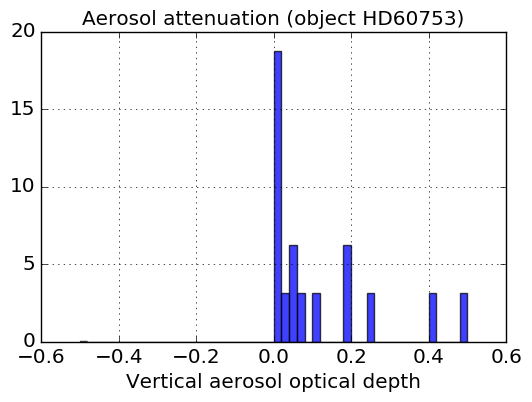

In [147]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto2.pdf')
plt.savefig(figfilename)

### Angstrom

In [148]:
GetMeanAndSigma(fitoptparam_cut2[:,2])

(2.8780000000000001, 7.359, 255.0)

In [149]:
print "median = ",np.median(fitoptparam_cut2[:,2])
print "average = ",np.average(fitoptparam_cut2[:,2])
print "std = ",np.std(fitoptparam_cut2[:,2])

median =  -0.0366637991365
average =  2.87834249953
std =  7.35991447772


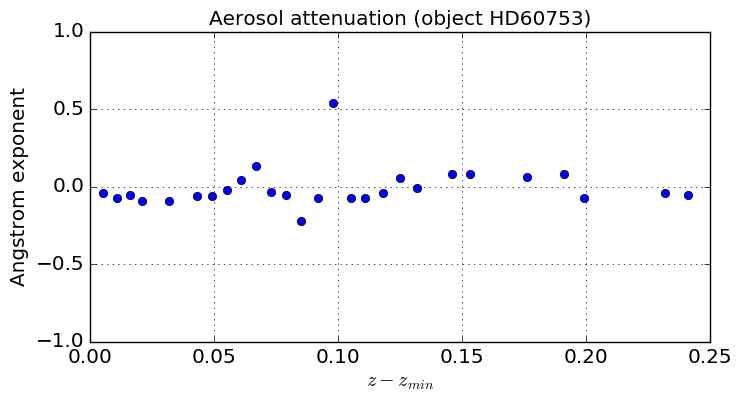

In [150]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz2.pdf')
plt.savefig(figfilename)

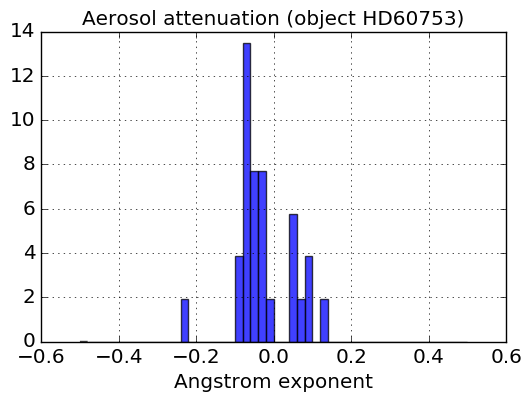

In [151]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto2.pdf')
plt.savefig(figfilename)

In [152]:
XMIN=0.65
XMAX=1.3

In [153]:
XminBin=np.arange(XMIN,XMAX,0.05)
XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)

In [154]:
XaverBin=(XminBin+XmaxBin)/2
    

In [155]:
print XminBin
print XmaxBin
print XaverBin

[ 0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15  1.2
  1.25]
[ 0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15  1.2   1.25
  1.3 ]
[ 0.675  0.725  0.775  0.825  0.875  0.925  0.975  1.025  1.075  1.125
  1.175  1.225  1.275]


In [156]:
theibin=np.where(np.logical_and(XminBin<=0.84,XmaxBin>0.84))

In [157]:
len(XminBin)

13

In [158]:
print theibin[0][0]

3


In [159]:
a=np.empty(0)

In [160]:
a=np.append(a,1)

In [161]:
a

array([ 1.])

### first simple model without Rayleigh 

In [162]:
def fullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c 

In [163]:
def badjacfullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    jac1=1 
    jac2=x**c
    jac3=b*x**c*np.log(x)
    return np.array([jac1,jac2,jac3])

In [164]:
#def myDfun( a,b,c, xdata, ydata, f ) :
def myDfun( xdata,a,b,c) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    res = np.vstack( ( jac1, jac2 , jac3 ) ).T
    return res

In [198]:
def FitFullExtinct(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,1.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    
    popt, pcov = curve_fit(fullextinct,x,y,sigma=ey,jac=myDfun,bounds=([0,0.,0.1], [0.5, 0.5, 4.]))
    #popt, pcov = curve_fit(fullextinct,x,y,sigma=ey,jac=myDfun)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

### second complex  model with Rayleigh

In [166]:
def fullextinct_r(x, a, b, c,d ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c + d*x**4

In [167]:
def myDfun_r( xdata,a,b,c,d) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    jac4=xdata**4
    res = np.vstack( ( jac1, jac2 , jac3, jac4 ) ).T
    return res

In [204]:
def FitFullExtinct_r(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,0.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=True)
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=False)
    popt, pcov = curve_fit(fullextinct_r,x,y,sigma=ey,jac=myDfun_r,bounds=([0,0.,0.1,0.], [0.5, 0.5, 3.,0.5]))
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [196]:
def NonLinearFitExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol extinct for object {}'):
    """
    Fit without rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS-2):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
        
        
    popt,perr=FitFullExtinct(all_X,all_Y,all_EY)  # No Rayleigh
    #popt,perr=FitFullExtinct_r(all_X,all_Y,all_EY)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red")                      
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

In [182]:
def NonLinearFitExtinction2_r(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol + resid rayleigh extinct  for object {}'):
    
    """
    Fit with Rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS-2):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
        
        
    #popt,perr=FitFullExtinct(all_X,all_Y,all_EY)  
    popt,perr=FitFullExtinct_r(all_X,all_Y,all_EY)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red")                      
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio_r.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

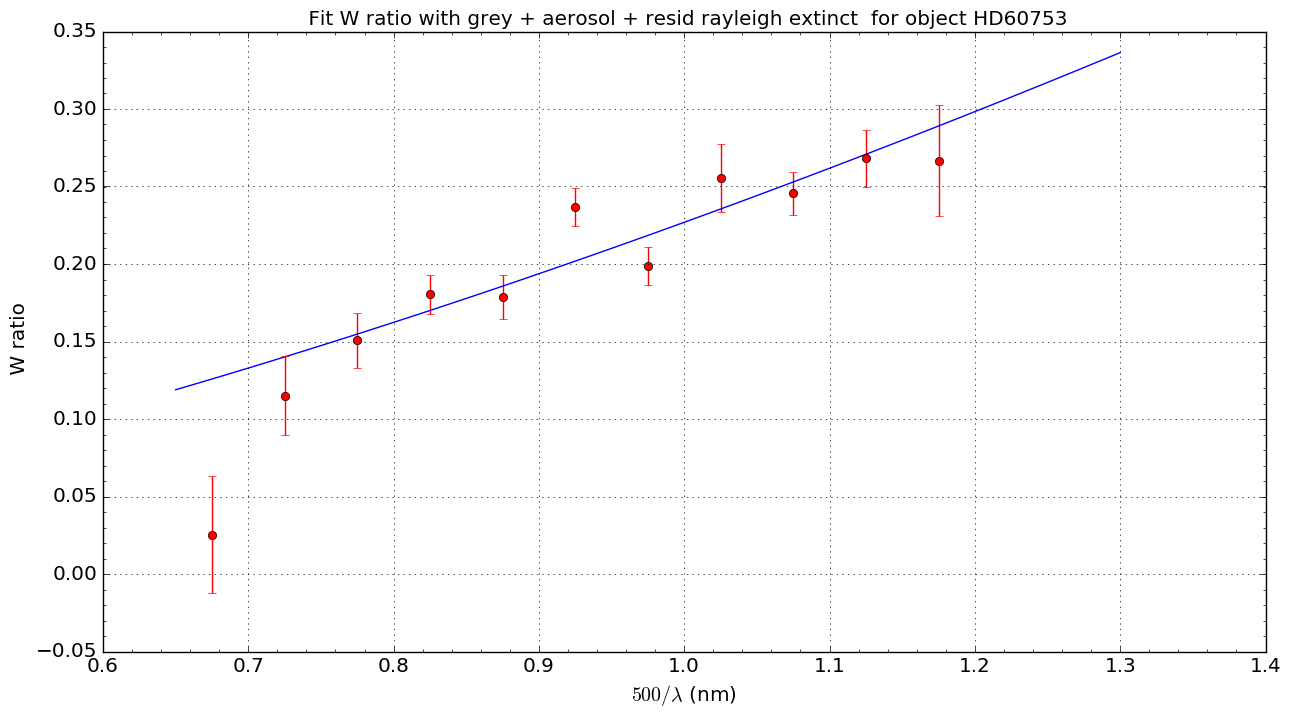

In [205]:
popt1,perr1=NonLinearFitExtinction2_r(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [206]:
popt1

array([  2.10995192e-13,   2.26909938e-01,   1.50058833e+00,
         2.47971167e-14])

In [207]:
perr1

array([  2.1756973 ,   1.13897221,  26.35545594,   1.07190807])

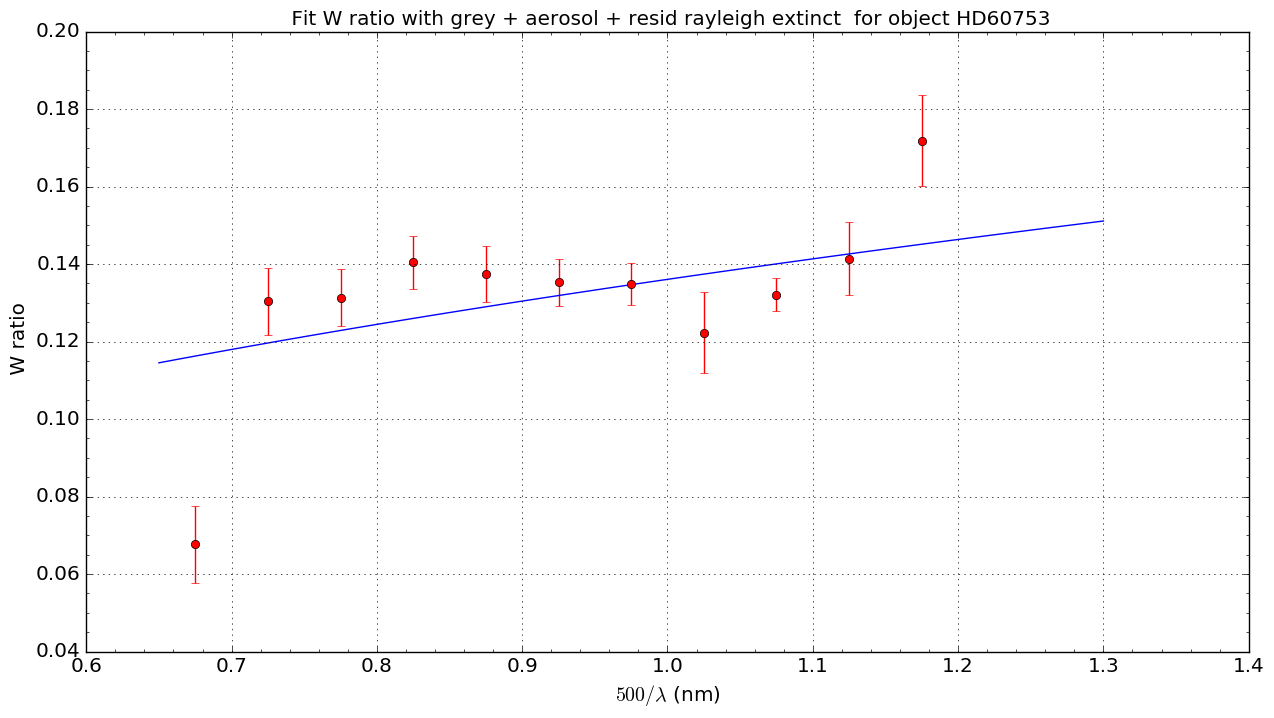

In [208]:
popt2,perr2=NonLinearFitExtinction2_r(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [209]:
popt2

array([  3.16852505e-16,   1.36037884e-01,   4.00093562e-01,
         3.17208335e-15])

In [210]:
perr2

array([ 15.01981639,  14.75624527,  51.30312929,   0.2649195 ])